In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 990)
pd.set_option('display.max_columns', 990)
import lightgbm as lgbm
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, average_precision_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
import eli5
from sklearn.dummy import DummyClassifier
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

C:\Users\gmanf\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\gmanf\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load Data

In [3]:
players4factors = pd.read_csv('players4factors.csv')

In [4]:
teams4factors = pd.read_csv('teams4factors.csv')

In [5]:
teams_stats = pd.read_csv('teams_stats.csv')

In [6]:
players_stats = pd.read_csv('players_stats.csv')

In [7]:
shots = pd.read_csv('shots_log.csv')

In [108]:
nba_teams = pd.read_csv('nba_teams.csv')

## Useful Functions

In [8]:
# This function uses Hyperopt for finding the best parameters of a LightGBM Classifier through cross-validation
def search_best_lgbm(X,y,n_trials, max_max_depth=20, max_max_bin=400, max_num_leaves=220, max_lrate=0.1):
    def evaluate_model(params):

        model = lgbm.LGBMClassifier(max_depth=params['max_depth'], 
                                    num_leaves=params['num_leaves'],
                                    learning_rate =params['learning_rate'],
                                    max_bin= params['max_bin'], 
                                    metric= ['auc', 'binary_logloss']
                                     )
        cv = cross_validate(model, X, y, cv=5, return_train_score=True)
        

        return {
            'num_leaves': params['num_leaves'],
            'max_depth': params['max_depth'],
            'learning_rate': params['learning_rate'],
            'max_bin': params['max_bin'],
            'Accuracy_TRAIN': cv['train_score'].mean(),
            'Accuracy_CVAL': cv['test_score'].mean(),
            
            }
    def objective(params):
        res = evaluate_model(params)
        res['loss'] = - res['Accuracy_CVAL']
        res['status'] = STATUS_OK
        return res 

    hyperparameter_space = {
            'learning_rate': hp.uniform('learning_rate', 0.0005, max_lrate),
            'num_leaves': hp.choice('num_leaves', range(40, max_num_leaves)),
            'max_depth': hp.choice('max_depth', range(2, max_max_depth)),
            'max_bin': hp.choice('max_bin', range(5, max_max_bin)),
    }
    trials = Trials()
    best = fmin(
        objective,
        space=hyperparameter_space,
        algo=tpe.suggest,
        max_evals=n_trials,
        trials=trials
    )
    experiment_results = pd.DataFrame(trials.results).sort_values(by='loss').reset_index(drop=True)
    return experiment_results
    

In [9]:
def model_evaluation(model, X, y):
    cv = cross_validate(model, X, y, cv=5)
    accuracy = cv['test_score'].mean()
    print(color.GREEN+color.BOLD+color.UNDERLINE+'Validation Results:'+color.END)
    print('Accuracy: '+color.BOLD+'{} %'.format(round(accuracy*100,2))+color.END)
    probas = cross_val_predict(model, X, y, cv=5,  method='predict_proba')
    roc_auc = roc_auc_score(y, probas[:,1])
    print('ROC-Area Under the Curve: '+color.BOLD+'{} %'.format(round(roc_auc*100,2))+color.END)
    precision, recall,_ = precision_recall_curve(y, probas[:,1])
    pr_auc = auc(recall, precision)
    print('Precision-Recall Area Under the Curve: '+color.BOLD+'{} %'.format(round(pr_auc*100,2))+color.END)
    return probas, accuracy, roc_auc, pr_auc

def model_evaluation_noprint(model, X, y):
    cv = cross_validate(model, X, y, cv=5)
    accuracy = cv['test_score'].mean()
    probas = cross_val_predict(model, X, y, cv=3,  method='predict_proba')
    roc_auc = roc_auc_score(y, probas[:,1])
    precision, recall,_ = precision_recall_curve(y, probas[:,1])
    pr_auc = auc(recall, precision)
    return probas, accuracy, roc_auc, pr_auc
    
def plot_prcurve(probas, X, y):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(8,4))
    naive_model = DummyClassifier(strategy='stratified')
    naive_probas = cross_val_predict(naive_model, X, y, cv=5,  method='predict_proba')
    precision_naive, recall_naive, _ = precision_recall_curve(y, naive_probas[:,1])
    ax = sns.lineplot(recall_naive, precision_naive, label='No Skill Model', ci=False)
    precision, recall,_ = precision_recall_curve(y, probas[:,1])
    ax = sns.lineplot(recall, precision, markers=True, ci=False, label='Our Model')
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.set_xlim(xmin=0, xmax=1)
    ax.grid(color='black', linestyle='-', linewidth=0.1)
    plt.legend()
    plt.title('Precision-Recall Curves', fontsize=20)
    plt.show()
    

In [10]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _y = p.get_y() + p.get_height() / 2
            _x = p.get_x() + p.get_width()
            value = '{:.2f}%'.format(p.get_width())
            ax.text(_x+2.5, _y, value, ha="center", fontsize=13, 
                   # color='darkblue'
                   ) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)

In [11]:
# I add final outcome of games to the teams4factors dataframe
teams4factors = teams4factors.merge(teams_stats[['GAME_ID', 'TEAM_ID', 'WL']], on=['GAME_ID', 'TEAM_ID'], how='left')

In [12]:
players4factors.shape

(92300, 19)

In [13]:
# I add final outcome of games to the players4factors dataframe
players4factors = players4factors.merge(teams_stats[['GAME_ID', 'TEAM_ID', 'WL']], on=['GAME_ID', 'TEAM_ID'], how='left')

In [14]:
players4factors.head(1)

SEASON_ID          SEASON     STAGE   GAME_ID     TEAM_ID  \
0      41996  1996-97 Season  Playoffs  49600078  1610612748   

  TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID     PLAYER_NAME START_POSITION  \
0               MIA     Miami        469  Jamal Mashburn              F   

   MINS_PLAYED  EFG_PCT  FTA_RATE  TM_TOV_PCT  OREB_PCT  OPP_EFG_PCT  \
0           26    0.474     0.395       0.189     0.261        0.479   

   OPP_FTA_RATE  OPP_TOV_PCT  OPP_OREB_PCT WL  
0          0.34        0.125         0.462  L

# Problem Definition

I would like to analyze vintage NBA teams through new Machine Learning techniques. Some of the things I will explore are:
- Dean Oliver's Four Factors
- Importance of the Four Factors for different teams
- Most important players per team
- Shooting Analysis per team

Now I know that with most of the things I'm doing here I'm not even scratching the surface compared to what current NBA Data Teams are probably doing. But they still look like decent exercises to try with these data.

# Oliver's Four Factors

While trying to answer the question "How do basketball teams win games?", Dean Oliver identified what he called the "Four Factors of Basketball Success"
- Shooting (40%)
- Turnovers (25%)
- Rebounding (20%)
- Free Throws (15%)

The weights for each factor were approximations assigned by himself. Additionally, in reality there are 8 factors, because for each team you have their 4 factors and the performance of the opponent on the same 4 factors.

Let's analyze each factor individually

### 1. Shooting (EFG%)
The shooting factor is measured using Effective Field Goal Percentage (eFG%). The formula for both offense and defense is (FG + 0.5 * 3P) / FGA.

### 2. Turnovers (TOV_PCT)
The turnover factor is measured using Turnover Percentage (TOV%). The formula for both offense and defense is TOV / (FGA + 0.44 * FTA + TOV).

### 3. Rebounding (OFF_REB_PCT)
The rebounding factor is measured using Offensive and Defensive Rebound Percentage (ORB% and DRB%, respectively). The formula for offense is ORB / (ORB + Opp DRB), while the formula for defense is DRB / (Opp ORB + DRB)

### 4. Free Throws Rate (FTA_RATE)
The free throw factor is a measure of both how often a team gets to the line and how often they make them. The formula for both offense and defense is FT / FGA.

Let's first see how well we can predict any given NBA game by knowing the 4 factors (or 8 factors in reality). We use data from 1996 to 1999 to train and cross-validate the model, leaving the 1999-00 Season for pure testing afterwards.

In [15]:
train = teams4factors[teams4factors['SEASON']!='1999-00 Season']

In [16]:
test = teams4factors[teams4factors['SEASON']=='1999-00 Season']

In [17]:
X = train.iloc[:,7:-1]
y = [1 if x=='W' else 0 for x in train.WL]

In [18]:
X_test = test.iloc[:,7:-1]
y_test = [1 if x=='W' else 0 for x in test.WL]

In [19]:
results = search_best_lgbm(X,y,50)
results.head(3)

100%|███████████████████████████████████████████████| 50/50 [00:54<00:00,  1.10s/trial, best loss: -0.9190087985513105]


num_leaves  max_depth  learning_rate  max_bin  Accuracy_TRAIN  \
0          40         19       0.099575      225        0.999433   
1         146         17       0.089526      135        1.000000   
2         146         17       0.088281      225        1.000000   

   Accuracy_CVAL      loss status  
0       0.919009 -0.919009     ok  
1       0.918251 -0.918251     ok  
2       0.917497 -0.917497     ok

In [20]:
best = dict(results.iloc[0,:4])
best_model = lgbm.LGBMClassifier(**best)

In [21]:
best_model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.09957488690101882,
               max_bin=225, max_depth=19, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=40, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [22]:
best_model.score(X_test, y_test)

0.9231987331749802

In [23]:
probas, accuracy, roc_auc, pr_auc = model_evaluation(best_model, X_test, y_test)

Validation Results:
Accuracy: 92.04 %
ROC-Area Under the Curve: 97.61 %
Precision-Recall Area Under the Curve: 97.63 %


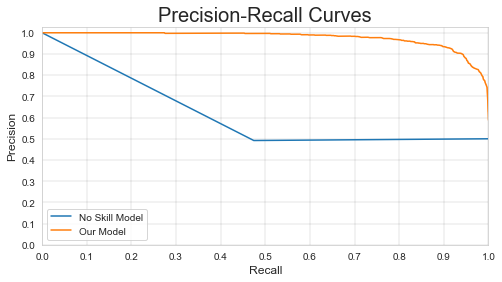

In [24]:
plot_prcurve(probas, X_test, y_test)

We can correctly predict almost 92% of NBA results on the testing set with Oliver's 4 factors. Definitely good considering lots of games are defined by a couple of points only. It's not hard to see why his theory became well-known.

Now let's see the weight assigned to each factor in our Gradient Boosting model. The idea is to either corroborate or discuss the weights that he initially assigned to each factor.

In [25]:
importances = eli5.explain_weights_df(best_model)

In [26]:
table = pd.DataFrame()
table['Factors'] = ['Shooting', 'Rebounding', 'Turnovers', 'Free Throws']
shooting = round((importances[importances.feature=='EFG_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_EFG_PCT'].weight.iloc[0])*100,1)
rebounding = round((importances[importances.feature=='OREB_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_OREB_PCT'].weight.iloc[0])*100,1)
turnovers = round((importances[importances.feature=='TM_TOV_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_TOV_PCT'].weight.iloc[0])*100,1)
free_throws = round((importances[importances.feature=='FTA_RATE'].weight.iloc[0] + importances[importances.feature=='OPP_FTA_RATE'].weight.iloc[0])*100,1)
table['Olivers Original Weight'] = [40.0, 20.0, 25.0, 15.0]
table['Weight'] = [shooting, rebounding, turnovers, free_throws]
table

Factors  Olivers Original Weight  Weight
0     Shooting                     40.0    53.8
1   Rebounding                     20.0    15.2
2    Turnovers                     25.0    20.2
3  Free Throws                     15.0    10.8

So according to our model, Shooting is around 14% more important than Oliver's original estimations. The other three factors are a bit less important than what he said. The order is the same though: Shooting > Turnovers > Rebounding > Free Throws

My idea for this notebook is, using these factors as predictors, to create a separate model for each vintage team. Then we will know if for certain teams the weights we just saw are different. It would make perfect sense that for some teams some factors are more important than others for predicting whether they win or lose.

I will first use Seattle Supersonics 96-97 as example. For some reason I used to love this team when I was a kid in the 90's. I guess something about their name, having Shawn Kemp on the team... Also that they are from Seattle and I used to listen to Nirvana a lot at that time. Just thinking about them takes my back to those good-old days, even though I grew up on the other side of the world.

# Four Factors Importance (Seattle Supersonics example)

In [27]:
sonics96 = teams4factors[(teams4factors.SEASON=='1996-97 Season') & ((teams4factors.TEAM_ABBREVIATION=='SEA'))]

In [28]:
X = sonics96[['EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'OREB_PCT', 'OPP_EFG_PCT', 'OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT']]
y = [1 if x=='W' else 0 for x in sonics96.WL]

In [29]:
results_sonics = search_best_lgbm(X,y,200)
results.head(3)

100%|██████████████████████████████████████████████| 200/200 [00:29<00:00,  6.84trial/s, best loss: -0.902923976608187]


num_leaves  max_depth  learning_rate  max_bin  Accuracy_TRAIN  \
0          40         19       0.099575      225        0.999433   
1         146         17       0.089526      135        1.000000   
2         146         17       0.088281      225        1.000000   

   Accuracy_CVAL      loss status  
0       0.919009 -0.919009     ok  
1       0.918251 -0.918251     ok  
2       0.917497 -0.917497     ok

In [30]:
best = dict(results.iloc[0,:4])
best_model = lgbm.LGBMClassifier(**best)

In [31]:
probas, accuracy, roc_auc, pr_auc = model_evaluation(best_model, X, y)

Validation Results:
Accuracy: 86.96 %
ROC-Area Under the Curve: 93.97 %
Precision-Recall Area Under the Curve: 96.76 %


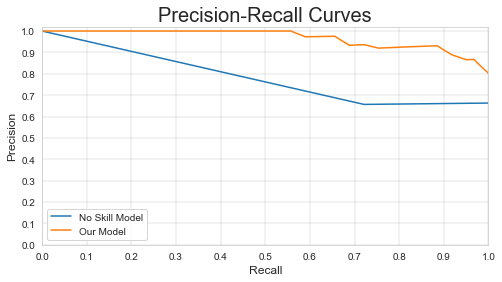

In [32]:
plot_prcurve(probas, X, y)

In [33]:
best_model.fit(X,y)
importances = eli5.explain_weights_df(best_model)

In [34]:
table = pd.DataFrame()
table['Factors'] = ['Shooting', 'Rebounding', 'Turnovers', 'Free Throws']
shooting = round((importances[importances.feature=='EFG_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_EFG_PCT'].weight.iloc[0])*100,0)
rebounding = round((importances[importances.feature=='OREB_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_OREB_PCT'].weight.iloc[0])*100,0)
turnovers = round((importances[importances.feature=='TM_TOV_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_TOV_PCT'].weight.iloc[0])*100,0)
free_throws = round((importances[importances.feature=='FTA_RATE'].weight.iloc[0] + importances[importances.feature=='OPP_FTA_RATE'].weight.iloc[0])*100,0)
table['Supersonics Importance'] = [shooting, rebounding, turnovers, free_throws]
table['Avg. NBA Team'] = [52.0, 16.0, 21.0, 11.0]
table

Factors  Supersonics Importance  Avg. NBA Team
0     Shooting                    45.0           52.0
1   Rebounding                     7.0           16.0
2    Turnovers                    38.0           21.0
3  Free Throws                    10.0           11.0

We see that the predictive power of Turnovers for 96-97 Seattle Supersonics is way higher than for the average NBA team. This suggests that fast-breaks were probably a huge part of their game, and the best way to do fast-breaks is by causing turnovers. The predictive power of Rebounds is particularly low for this team.

Text(0.0, 1.0, 'Four Factors Importance')

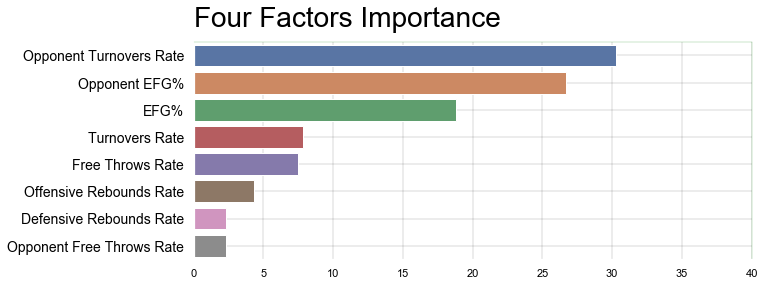

In [35]:
features_dict = dict({'EFG_PCT': 'EFG%', 'DEF_RATING': 'Defense', 'FTA_RATE': 'Free Throws Rate', 'TM_TOV_PCT': 'Turnovers Rate', \
                     'OREB_PCT': 'Offensive Rebounds Rate', 'OPP_OREB_PCT': 'Defensive Rebounds Rate', 'OPP_EFG_PCT': 'Opponent EFG%', \
                         'OPP_FTA_RATE': 'Opponent Free Throws Rate', 'OPP_TOV_PCT': 'Opponent Turnovers Rate'})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'black', \
           'xtick.color': 'black'})
fig, ax = plt.subplots(figsize=(10,4))
ax = sns.barplot(y=importances.feature.map(features_dict), x=importances.weight/importances.weight.sum()*100, )
ax.set_xticks(np.arange(0, (importances.weight.max()/importances.weight.sum()*100)+10, 5))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=14)
ax.grid(color='black', linestyle='-', linewidth=0.15)
ax.spines['right'].set_linewidth(0.2)
ax.spines['right'].set_color('green')
ax.spines['top'].set_linewidth(0.2)
ax.spines['top'].set_color('green')
#show_values_on_bars(ax)
plt.title('Four Factors Importance', fontsize=28, pad='15.0', loc='left')

The plot confirms that it is particularly the opponent's turnover rate that is such a great predictor of Seattle Supersonics' success. We see that their own turnover's rate is not as important. All of this strengthens the theory that this team relied heavily on fast breaks.

# Most Important players per team (Chicago Bulls example)

Now we will again make a model specifically for the team. In this case, we'll use 97-98 Chicago Bulls as example. But this time the predictors will be the individual players' performance on the four factors, rather than the team's totals. Then we can estimate the importance of each predictor and in this way we can estimate the importance of each player on predicting the final outcome of each game.
For this analysis I'd prefer to merge some of the 8 factors, to make the results' interpretation more intuititive. For example:
- Combine Offensive Rebounds Rate with Opponent's Offensive Rebounds Rate. Then we have only one factors that covers the entire rebounding spectrum of the player. The Opponent's Offensive Rebounds Rate measures how many offensive rebounds a player allowed his matchup to grab, so it is a good measure of his own's defensive rebounding performance.
- Combine Opponent's EFG% with Opponent's Turnover Rate and Opponent's Free Throws Rate: Then we have one factor that represents the player's defensive performance during the game.

So, in summary, we now have 5 factors for describing each player's performance: (1) EFG% (=shooting), (2) Rebounding, (3) Turnovers Rate, (4) Free Throws Rate, (5) Defense. So the total number of predictors will be "Number of players x 5".

Instead of adding the 5 factors for every player of the team, I will consider only the 8 players who played the most minutes. In this way we end up with 40 predictors for each game (8x5), which seems reasonable.

In [36]:
players4factors['REB'] = players4factors['OREB_PCT'] - players4factors['OPP_OREB_PCT']
players4factors['DEF'] = 1 - (0.7*players4factors['OPP_EFG_PCT'] + 0.15*players4factors['OPP_TOV_PCT'] + 0.15*players4factors['OPP_FTA_RATE'])

In [37]:
season97_players = players4factors[players4factors.SEASON=='1997-98 Season']

In [38]:
bulls97_players = season97_players[season97_players.TEAM_ABBREVIATION=='CHI'].reset_index(drop=True)

In [39]:
group_players = bulls97_players.groupby('PLAYER_NAME', as_index=False)[['MINS_PLAYED', 'EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', \
                                                                       'REB', 'DEF']].mean()

In [40]:
list_players = list(group_players.sort_values('MINS_PLAYED', ascending=False).reset_index(drop=True).iloc[:8,:]['PLAYER_NAME'].unique())

In [41]:
list_players

['Michael Jordan',
 'Scottie Pippen',
 'Dennis Rodman',
 'Toni Kukoc',
 'Luc Longley',
 'Ron Harper',
 'Steve Kerr',
 'Randy Brown']

In [42]:
bulls97_players = bulls97_players[bulls97_players.PLAYER_NAME.isin(list_players)].reset_index(drop=True)

Now that we have filtered the data set to leave only the players we want, we have to create one column for each PlayerxFactor combination. Since I'm not sure how to handle this with Pandas pivot option, I will just do it manually.

In [43]:
column_names=[]
for player in list_players:
    for column in ['EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'REB', 'DEF']:
        name = player + '_' + column
        column_names.append(name)
df_players = pd.DataFrame(index=list(bulls97_players.GAME_ID.unique()), columns=column_names)

We have a dataframe with each GAME_ID on the index and each PlayerxFactor combination as columns. But the values are all NaN so far. We need to fill in the corresponding values by looking them up in our previous data set.

In [44]:
for index, row in bulls97_players.iterrows():
    game = row['GAME_ID']
    player = row['PLAYER_NAME']
    for column in ['EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'REB', 'DEF']:
        name= player + '_' + column
        if name in df_players.columns:
            df_players.loc[game][name] = bulls97_players[(bulls97_players.GAME_ID==game) & (bulls97_players.PLAYER_NAME==player)][column].iloc[0]

In [45]:
df_players.fillna(0, inplace=True)

In [46]:
df_players = df_players.reset_index().rename(columns={'index': 'GAME_ID'})

In [47]:
df_players.head(2)

GAME_ID  Michael Jordan_EFG_PCT  Michael Jordan_FTA_RATE  \
0  29700884                   0.574                    0.147   
1  29700467                   0.397                    0.079   

   Michael Jordan_TM_TOV_PCT  Michael Jordan_REB  Michael Jordan_DEF  \
0                      0.140               0.069             0.58235   
1                      0.163               0.025             0.55595   

   Scottie Pippen_EFG_PCT  Scottie Pippen_FTA_RATE  Scottie Pippen_TM_TOV_PCT  \
0                   0.582                    0.197                      0.188   
1                   0.000                    0.000                      0.000   

   Scottie Pippen_REB  Scottie Pippen_DEF  Dennis Rodman_EFG_PCT  \
0               0.144              0.6754                  0.510   
1               0.000              0.0000                  0.396   

   Dennis Rodman_FTA_RATE  Dennis Rodman_TM_TOV_PCT  Dennis Rodman_REB  \
0                   0.245                     0.184              0.102   
1                   0.083                     0.170             -0.033   

   Dennis Rodman_DEF  Toni Kukoc_EFG_PCT  Toni Kukoc_FTA_RATE  \
0            0.57035               0.621                0.097   
1            0.52440               0.446                0.087   

   Toni Kukoc_TM_TOV_PCT  Toni Kukoc_REB  Toni Kukoc_DEF  Luc Longley_EFG_PCT  \
0                  0.093          -0.060         0.60325                0.000   
1                  0.183           0.055         0.47700                0.537   

   Luc Longley_FTA_RATE  Luc Longley_TM_TOV_PCT  Luc Longley_REB  \
0                   0.0                   0.000            0.000   
1                   0.0                   0.115           -0.096   

   Luc Longley_DEF  Ron Harper_EFG_PCT  Ron Harper_FTA_RATE  \
0          0.00000               0.588                0.300   
1          0.59485               0.490                0.077   

   Ron Harper_TM_TOV_PCT  Ron Harper_REB  Ron Harper_DEF  Steve Kerr_EFG_PCT  \
0                  0.133           0.114         0.62205               0.000   
1                  0.103          -0.015         0.55575               0.328   

   Steve Kerr_FTA_RATE  Steve Kerr_TM_TOV_PCT  Steve Kerr_REB  Steve Kerr_DEF  \
0                0.000                  0.000           0.000         0.00000   
1                0.138                  0.209           0.095         0.50055   

   Randy Brown_EFG_PCT  Randy Brown_FTA_RATE  Randy Brown_TM_TOV_PCT  \
0                0.000                 0.000                   0.000   
1                0.396                 0.125                   0.118   

   Randy Brown_REB  Randy Brown_DEF  
0            0.000           0.0000  
1           -0.144           0.5459

In [48]:
games = bulls97_players.drop_duplicates('GAME_ID').reset_index(drop=True)

In [49]:
df_players = df_players.merge(games[['GAME_ID', 'WL']], on='GAME_ID', how='left')

In [50]:
X = df_players.iloc[:,1:-1]
y = [1 if x=='W' else 0 for x in df_players.WL]

In [51]:
results = search_best_lgbm(X,y,200)
best = dict(results.iloc[0,:4])
best_model = lgbm.LGBMClassifier(**best)

100%|█████████████████████████████████████████████| 200/200 [00:29<00:00,  6.87trial/s, best loss: -0.8442857142857143]


In [52]:
probas, accuracy, roc_auc, pr_auc = model_evaluation(best_model, X, y)

Validation Results:
Accuracy: 84.43 %
ROC-Area Under the Curve: 82.57 %
Precision-Recall Area Under the Curve: 93.27 %


In [53]:
best_model.fit(X,y)
importances = eli5.explain_weights_df(best_model)

In [54]:
for i in range(len(importances.feature)):
    importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('EFG_PCT', 'EFG%')
    importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('DEF', 'Defense')
    importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('FTA_RATE', 'Free Throws Rate')
    importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('TM_TOV_PCT', 'Turnovers Rate')
    importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('REB', 'Rebounds Rate')
    importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('_', ' ')

importances = importances[importances.weight>0.025]

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'black', \
           'xtick.color': 'black'})
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(y=importances.feature, x=importances.weight/importances.weight.sum()*100, )
ax.set_xticks(np.arange(0, (importances.weight.max()/importances.weight.sum()*100)+5, 5))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=14)
ax.grid(color='black', linestyle='-', linewidth=0.15)
ax.spines['right'].set_linewidth(0.2)
ax.spines['right'].set_color('black')
ax.spines['top'].set_linewidth(0.2)
ax.spines['top'].set_color('black')
plt.title('Bulls Players Stats Importance', fontsize=24, pad='16.0')

Text(0.5, 1.0, 'Bulls Players Stats Importance')

Looks like Michael Jordan's Shooting is the most important predictor for Bulls' games, followed by Michael Jordan's defensive performance. From this it looks clear that MJ was the most important player of the team, but let's estimate the importance of each player anyway by summing the weights of each of the 5 factors for each player individually.

In [58]:
importances_new = importances.copy()
new_list_players=[]
for player in list_players:
    new_player = player.replace(" ", "_")
    new_list_players.append(new_player)

importances_new['player']=0
for i in range(len(importances_new)):
    for name in list_players:
        if name in importances_new.loc[i,'feature']:
            importances_new.loc[i,'player']=name
for i in range(len(importances_new)):
    importances_new.loc[i,'player'] = importances_new.loc[i,'player'].replace("_", " ")
player_importances = importances_new.groupby('player', 
                                        as_index=False)['weight'].sum().rename(
                                        columns={'weight':'EstimatedImportance'}).sort_values('EstimatedImportance', 
                                                                                ascending=False).reset_index(drop=True)

In [59]:
player_importances.head()

player  EstimatedImportance
0  Michael Jordan             0.474057
1   Dennis Rodman             0.158619
2     Randy Brown             0.084525
3      Ron Harper             0.046178
4      Toni Kukoc             0.040940

Text(0.5, 1.0, 'Most Important Players')

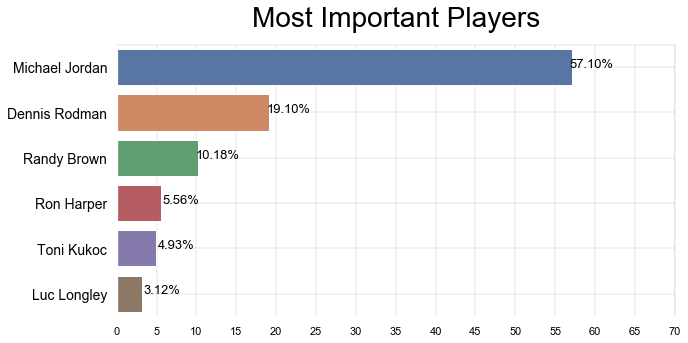

In [60]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'black', \
               'xtick.color': 'black'})
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(y=player_importances.player, x=player_importances.EstimatedImportance/player_importances.EstimatedImportance.sum()*100, )
ax.set_xticks(np.arange(0, (player_importances.EstimatedImportance.max()/player_importances.EstimatedImportance.sum()*100)+15, 5))
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=14)
ax.grid(color='black', linestyle='-', linewidth=0.1)
ax.spines['right'].set_linewidth(0.1)
ax.spines['right'].set_color('black')
ax.spines['top'].set_linewidth(0.1)
ax.spines['top'].set_color('black')
show_values_on_bars(ax)
plt.title('Most Important Players', fontsize=28, pad='18.0')

Of course Jordan is by far the most important player. One thing should be clarified here though, and it is that we are talking here about the importance of each player's performance for predicting the game's result. This is not equivalent to the players' importance to the team!

I will take a modern player as example to illustrate this point: James Harden. I would guess that if we do this exercise for the current Rockets' team, then the number of points scored by James Harden will appear as not important for predicting the score. Why? Because he always scores +30 pts, even if his team looses. So, in other words, knowing that James Harden scored, let's say, 32 points in a game, is not important for predicting if the Rockets won or lost, because he always scores that number no matter what. But this does not mean that his points are not important, of course. They are just not important for our predictive model, simply because that statistic is not very informative.

Going back to the Bulls' example, it is surprising to see Scottie Pippen so unimportant, but let's remember that this does not mean necesarily that his role was not important, but only that his performance is not important for predicting. Additionally, he barely played this season because of contract issues.

## Shooting Analysis

Now we'll change the focus to analyze the shooting aspect of the game. What I would like to find out is who the best shooters of each team are. For this, I will first create a Shot Prediction model, in which I take all of the shots in a shot-log, train and test the model. If this succeeds, we will have a model that can predict (to a decent accuracy I hope) whether any shot will go in.

Once we have this, we can, for each player, determine the difference between his actual Field Goal Percentage, and the Field Goal Percentage that an average NBA player would have considering the difficulty of the shots the player has taken. I will call this difference "Shooting Ability" and it will illustrate the players' shooting qualities.

As usual, I will pick a team as example to do this analysis. I will use Utah Jazz of 96-97.

In [61]:
shots_log = pd.read_csv('shots_log.csv')

In [62]:
shots_log.SEASON.unique()

array(['1996-97 Season', '1997-98 Season', '1998-99 Season',
       '1999-00 Season'], dtype=object)

In [63]:
shots_log.SHOT_DISTANCE = [x if x<40 else 40 for x in shots_log.SHOT_DISTANCE]

Text(0.5, 1.0, 'Shot Conversion vs. Distance to Basket')

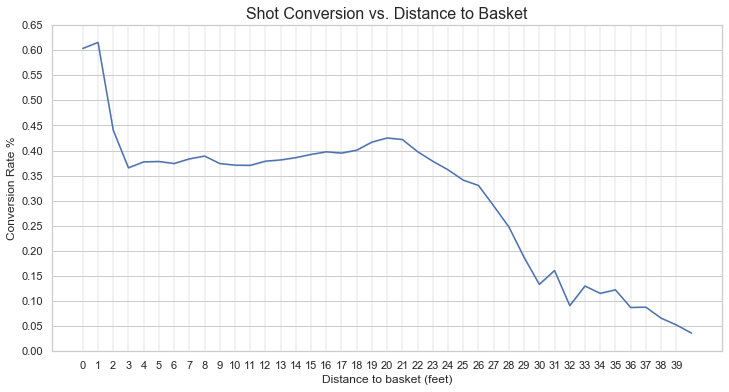

In [64]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.lineplot(data=shots_log, x='SHOT_DISTANCE', y='SHOT_MADE_FLAG', ci=False)
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
ax.set_xlabel('Distance to basket (feet)', fontsize=12)
ax.set_ylabel('Conversion Rate %', fontsize=12)
ax.set_xticks(np.arange(0,40,1))
ax.set_yticks(np.arange(0,0.7,0.05))
plt.title('Shot Conversion vs. Distance to Basket', fontsize=16)

It is interesting to see that shot probability of going in seems to be the same from aroun 3 feet to 20 feet. Only after 20 feet the chances of going in start going down again. From 0 to 3 feet the decrease is also very clear.

Let's just train the model now. I will use the 98-99 and 99-00 Season for training and cross-validation to check how well we do.

In [65]:
train = shots_log[(shots_log.SEASON=='1999-00 Season') | (shots_log.SEASON=='1998-99 Season')].reset_index(drop=True)

In [66]:
X_train = pd.concat([train[['PERIOD', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y']], 
                pd.get_dummies(train.ACTION_TYPE),
                pd.get_dummies(train.SHOT_TYPE), 
                pd.get_dummies(train.SHOT_ZONE_BASIC),
                pd.get_dummies(train.SHOT_ZONE_AREA)], 
                axis=1)
y_train = train['SHOT_MADE_FLAG']

In [67]:
results = search_best_lgbm(X_train, y_train, 20, max_lrate=0.15, max_num_leaves=300, max_max_depth=50, max_max_bin=800)

100%|███████████████████████████████████████████████| 20/20 [03:22<00:00, 10.10s/trial, best loss: -0.6405776635574595]


In [68]:
results.head(3)

num_leaves  max_depth  learning_rate  max_bin  Accuracy_TRAIN  \
0          72         35       0.043905       44        0.642253   
1          77         45       0.017370      714        0.642114   
2         229          9       0.057637      566        0.643670   

   Accuracy_CVAL      loss status  
0       0.640578 -0.640578     ok  
1       0.640459 -0.640459     ok  
2       0.640402 -0.640402     ok

We can predict with 64% accuracy whether any given shot will go in. At first this does not seem very good, but in reality I think it's pretty hard to predict this. Of course we would do better if we add information about who is the player that is shooting, but we're not interested in that because what we want to model is the probability that an average NBA player will make the shot, not the specific player. From what I find online, I guess that the model is reasonably good. The best I could find is this one in which they obtain a 65% accuracy, so we're not that far away. In that model they included some relevant things we don't have, such as the distance to the closest defender, and that defender's height.

We also see no signs whatsoever of overfitting, as we do equally good on training and on cv results.

In summary, it appears that our shot prediction model is decent and good enough to use it for what we want.

In [69]:
best = dict(results.iloc[0,:4])
best_model = lgbm.LGBMClassifier(**best)

In [70]:
X = pd.concat([shots_log[['PERIOD', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y']], 
                pd.get_dummies(shots_log.ACTION_TYPE),
                pd.get_dummies(shots_log.SHOT_TYPE), 
                pd.get_dummies(shots_log.SHOT_ZONE_BASIC),
                pd.get_dummies(shots_log.SHOT_ZONE_AREA)], 
                axis=1)
y = shots_log.SHOT_MADE_FLAG
best_model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.04390466077022362,
               max_bin=44, max_depth=35, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=72, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [71]:
shots_log['shot_probability'] = best_model.predict_proba(X)[:,1]

In [72]:
by_player = shots_log.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)['shot_probability'].mean()

In [73]:
by_player.shot_probability.mean()

0.44794009673402724

In [74]:
len(shots_log)

729649

In [75]:
teams_short = teams_stats.drop_duplicates(['TEAM_NAME', 'TEAM_ABBREVIATION'])[['TEAM_NAME', 'TEAM_ABBREVIATION']].reset_index(drop=True)

In [76]:
shots_log = shots_log.merge(teams_short, on='TEAM_NAME', how='left')

In [77]:
jazz96_shots = shots_log[(shots_log.TEAM_ABBREVIATION=='UTA') & (shots_log.SEASON=='1996-97 Season')].reset_index(drop=True)

In [78]:
shots_proba = jazz96_shots.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)['shot_probability'].mean()

In [79]:
jazz96_stats = players_stats[(players_stats.TEAM_ABBREVIATION=='UTA') & (players_stats.SEASON=='1996-97 Season')].reset_index(drop=True)

In [80]:
group_stats = jazz96_stats.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)[['FGM', 'FGA']].sum()

In [81]:
point_per_game = jazz96_stats.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)[['PTS', 'FGA']].mean().rename(columns={'FGA': 'ShotAttempts'})

In [82]:
group_stats['FG_PCT'] = group_stats['FGM'] / group_stats['FGA']

In [83]:
stats = group_stats.merge(shots_proba, on=['PLAYER_ID', 'PLAYER_NAME'], how='left').merge(point_per_game, on=['PLAYER_ID', 'PLAYER_NAME'], how='left')

In [84]:
stats['ShootingAbility'] = stats['FG_PCT'] - stats['shot_probability']

In [85]:
stats.head(2)

PLAYER_ID    PLAYER_NAME    FGM     FGA    FG_PCT  shot_probability  \
0        156   Antoine Carr  292.0   605.0  0.482645          0.443168   
1        204  Jeff Hornacek  503.0  1063.0  0.473189          0.437295   

         PTS  ShotAttempts  ShootingAbility  
0   6.872549      5.931373         0.039477  
1  14.529412     10.421569         0.035894

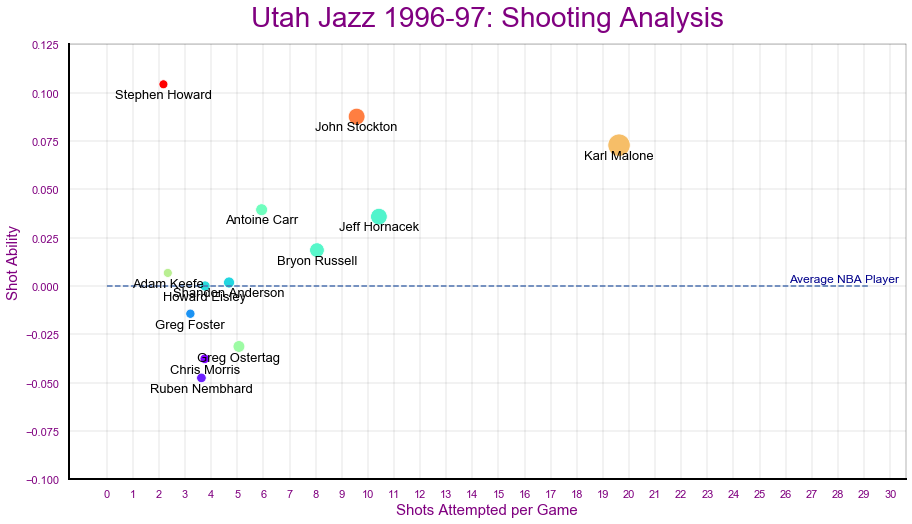

In [86]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'purple', \
           'xtick.color': 'purple'})
graph = stats[stats.PTS>3].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15,8))

ax = sns.scatterplot(data=graph, x='ShotAttempts', y='ShootingAbility', size='PTS', hue='FG_PCT', \
                    palette='rainbow', sizes=(80, 500))
ax = sns.lineplot(x=[0,graph.PTS.max()+2], y=[0,0], label='Average Player')
#ax = sns.lineplot(x=[0.449,0.449], y=[-0.125,0.125], linewidth=5, color='darkblue')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_linewidth(0.3)
ax.spines['right'].set_color('black')
ax.spines['top'].set_linewidth(0.3)
ax.spines['top'].set_color('black')
ax.lines[0].set_linestyle("--")

ax.grid(color='black', linestyle='-', linewidth=0.1)

ax.set_xticks(np.arange(0,graph.PTS.max()+3,1))
ytick_min = myround(graph.ShootingAbility.min()-0.05)
ytick_max = myround(graph.ShootingAbility.max()+0.05)
ax.set_yticks(np.arange(ytick_min,ytick_max,0.025))

ax.get_legend().set_visible(False)
ax.set_ylabel('Shot Ability', fontsize=15, color='purple')
ax.set_xlabel('Shots Attempted per Game', fontsize=15, color='purple')
plt.title('Utah Jazz 1996-97: Shooting Analysis', fontsize=28, color='purple', pad='18.0')
ax.text(x=graph.PTS.max()-1, y=0.001, s='Average NBA Player', fontsize=12, verticalalignment='bottom', color='darkblue')
for x,y,z in zip(graph.ShotAttempts, graph.ShootingAbility, graph.PLAYER_NAME):
    point = (x,y)
    ax.text( x=x, y=y-0.0025, s = z, horizontalalignment='center', verticalalignment='top', fontsize=13, color='black')

So the interpretation here is:
- Players who are on top are better shooters, as estimated by their FG% compared to the FG% an average NBA player would have according to all the shots that the player took.

- Players who are on the right shoot more often than those over the left.
- The sizes of the nodes are according to the number of points per game the player scores.

So, in a fair world, better shooters would shoot more, so we would expect most players to be located either on the upper right (good shooters) or the lower left (bad shooters) sides of the graph. But of course the world is not that fair, and we may find good shooters who don't shoot as often, and bad shooters who take lots of shots. This kind of analysis could be interesting for an NBA team to study their shots decision making.

It does not look bad for the Jazz team, as we see that Stockton, Hornancek and Malone are the ones who take the most shots and are also the best shooters. The only exception is Stephen Howard, who we see was the best shooter of the team but did not shoot as often.

Let's summarize everything that we did so far inside functions, so that later I can just call them for each NBA team and make a complete analysis of all.

In [97]:
def create_players_model(data, team='All', season='All', min_minutes=20, n_trials=50):
    df = data.copy()
    if season!='All':
        df = df[df.SEASON==season]
    if team != 'All':
        df = df[df.TEAM_ABBREVIATION==team]
    group_players = df.groupby('PLAYER_NAME', as_index=False)[['MINS_PLAYED', 'EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', \
                                                                       'REB', 'DEF']].mean()
    list_players = list(group_players.sort_values('MINS_PLAYED', ascending=False).head(8)['PLAYER_NAME'])
    df = df[df.PLAYER_NAME.isin(list_players)].reset_index(drop=True)
    
    column_names=[]
    for player in list_players:
        for column in ['EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'REB', 'DEF']:
            name = player + '_' + column
            column_names.append(name)
    df_players = pd.DataFrame(index=list(df.GAME_ID.unique()), columns=column_names)
    for index, row in df.iterrows():
        game = row['GAME_ID']
        player = row['PLAYER_NAME']
        for column in ['EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'REB', 'DEF']:
            name= player + '_' + column
            if name in df_players.columns:
                df_players.loc[game][name] = df[(df.GAME_ID==game) & (df.PLAYER_NAME==player)][column].iloc[0]
    df_players.fillna(0, inplace=True)
    df_players = df_players.reset_index().rename(columns={'index': 'GAME_ID'})
    games = df.drop_duplicates('GAME_ID').reset_index(drop=True)
    df_players = df_players.merge(games[['GAME_ID', 'WL']], on='GAME_ID', how='left')
    X = df_players.iloc[:,1:-1]
    y = [1 if x=='W' else 0 for x in df_players.WL]
    results = search_best_lgbm(X,y,n_trials)
    best = dict(results.iloc[0,:4])
    best_model = lgbm.LGBMClassifier(**best)
    
    # Determining Features and Players Importances
    best_model.fit(X,y)
    feature_importances = eli5.explain_weights_df(best_model)
    importances = feature_importances.copy()
    new_list_players=[]
    for player in list_players:
        new_player = player.replace(" ", "_")
        new_list_players.append(new_player)
    importances['player']=0
    for i in range(len(importances)):
        for name in new_list_players:
            if name in importances.loc[i,'feature']:
                importances.loc[i,'player']=name
    for i in range(len(importances)):
        importances.loc[i,'player'] = importances.loc[i,'player'].replace("_", " ")
    player_importances = importances.groupby('player', as_index=False)['weight'].sum().rename(columns={'weight':'EstimatedImportance'}).sort_values('EstimatedImportance', ascending=False).reset_index(drop=True)
    
    return X, y, best_model, player_importances, feature_importances

def create_team_model(data, team='All', season='All', n_trials=50):
    df = data.copy()
    if season!='All':
        df = df[df.SEASON==season]
    if team != 'All':
        df = df[df.TEAM_ABBREVIATION==team]
    X = df[['EFG_PCT', 'FTA_RATE', 'TM_TOV_PCT', 'OREB_PCT', 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'OPP_OREB_PCT', 'OPP_FTA_RATE']]
    y = [1 if x=='W' else 0 for x in df.WL]
    results = search_best_lgbm(X,y,n_trials)
    best = dict(results.iloc[0,:4])
    best_model = lgbm.LGBMClassifier(**best)
    return X, y, best_model

def summarize_importances_team(importances):
    table = pd.DataFrame()
    table['Factors'] = ['Shooting', 'Rebounding', 'Turnovers', 'Free Throws', 'TOTAL']
    shooting = round((importances[importances.feature=='EFG_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_EFG_PCT'].weight.iloc[0])*100,1)
    rebounding = round((importances[importances.feature=='OREB_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_OREB_PCT'].weight.iloc[0])*100,1)
    turnovers = round((importances[importances.feature=='TM_TOV_PCT'].weight.iloc[0] + importances[importances.feature=='OPP_TOV_PCT'].weight.iloc[0])*100,1)
    free_throws = round((importances[importances.feature=='FTA_RATE'].weight.iloc[0] + importances[importances.feature=='OPP_FTA_RATE'].weight.iloc[0])*100,1)
    table['Importance for them'] = [shooting, rebounding, turnovers, free_throws, 100.0]
    table['Importance for Avg. NBA Team'] = [50.3, 16.8, 20.7, 12.2, 100.0]
    return table

def plot_importances_team(importances):
    features_dict = dict({'EFG_PCT': 'EFG%', 'DEF_RATING': 'Defense', 'FTA_RATE': 'Free Throws Rate', 'TM_TOV_PCT': 'Turnovers Rate', \
                     'OREB_PCT': 'Off. Rebounds Rate', 'OPP_OREB_PCT': 'Def. Rebounds Rate', 'OPP_EFG_PCT': 'Opp. EFG%', \
                         'OPP_FTA_RATE': 'Opp. Free Throws Rate', 'OPP_TOV_PCT': 'Opp. Turnovers Rate'})
    sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'black', \
               'xtick.color': 'black'})
    fig, ax = plt.subplots(figsize=(14,4))
    ax = sns.barplot(y=importances.feature.map(features_dict), x=importances.weight/importances.weight.sum()*100, )
    ax.set_xticks(np.arange(0, (importances.weight.max()/importances.weight.sum()*100)+10, 5))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12, color='black')
    ax.grid(color='black', linestyle='-', linewidth=0.1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(0.3)
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(0.3)
    ax.spines['top'].set_color('black')
    plt.title('Four Factors Importance', fontsize=28, color='black', fontfamily='serif', loc="center", pad='16.0')
    plt.tight_layout()
    plt.show()

def plot_importances_players(importances):
    sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'black', \
               'xtick.color': 'black'})
    fig, ax = plt.subplots(figsize=(14,4))
    ax = sns.barplot(y=importances.player, x=importances.EstimatedImportance/importances.EstimatedImportance.sum()*100, )
    ax.set_xticks(np.arange(0, (importances.EstimatedImportance.max()/importances.EstimatedImportance.sum()*100)+10, 5))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=14, color='black')
    ax.grid(color='black', linestyle='-', linewidth=0.1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(0.3)
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(0.3)
    ax.spines['top'].set_color('black')
    show_values_on_bars(ax)
    plt.title('Most Important Players', fontsize=28, fontfamily='serif', loc="center", pad='16.0')
    plt.tight_layout()
    plt.show()
    
def plot_importances_player_features(importances):
    for i in range(len(importances.feature)):
        importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('EFG_PCT', 'EFG%')
        importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('DEF', 'Defense')
        importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('FTA_RATE', 'Free Throws Rate')
        importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('TM_TOV_PCT', 'Turnovers Rate')
        importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('REB', 'Rebounds Rate')
        importances.loc[i,'feature'] = importances.loc[i,'feature'].replace('_', ' ')
    
    importances = importances.sort_values('weight', ascending=False).iloc[:10,:]
    
    sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'black', \
               'xtick.color': 'black'})
    fig, ax = plt.subplots(figsize=(14,4))
    ax = sns.barplot(y=importances.feature, x=importances.weight/importances.weight.sum()*100, palette='icefire' )
    ax.set_xticks(np.arange(0, (importances.weight.max()/importances.weight.sum()*100)+5, 5))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=10)
    
    ax.grid(color='black', linestyle='-', linewidth=0.15)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(0.3)
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(0.3)
    ax.spines['top'].set_color('black')
    plt.title('Most Important Predictors',fontsize=28, fontfamily='serif', loc="center", pad='16.0')
    plt.tight_layout()
    plt.show()
    
def get_shooting_analysis(team, season):
    thisteam_shots = shots_log[(shots_log.TEAM_ABBREVIATION==team) & (shots_log.SEASON==season)].reset_index(drop=True)
    shots_proba = thisteam_shots.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)['shot_probability'].mean()
    thisteam_stats = players_stats[(players_stats.TEAM_ABBREVIATION==team) & (players_stats.SEASON==season)].reset_index(drop=True)
    group_stats = thisteam_stats.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)[['FGM', 'FGA']].sum()
    point_per_game = thisteam_stats.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)[['PTS', 'FGA']].mean().rename(columns={'FGA': 'ShotAttempts'})
    group_stats['FG_PCT'] = group_stats['FGM'] / group_stats['FGA']
    stats = group_stats.merge(shots_proba, on=['PLAYER_ID', 'PLAYER_NAME'], how='left').merge(point_per_game, on=['PLAYER_ID', 'PLAYER_NAME'], how='left')
    stats['ShootingAbility'] = stats['FG_PCT'] - stats['shot_probability']
    
    sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white', 'text.color': 'black', 'ytick.color': 'black', \
           'xtick.color': 'black'})
    graph = stats[stats.FGA>200].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(14,8))

    ax = sns.scatterplot(data=graph, x='ShotAttempts', y='ShootingAbility', size='PTS', hue='FG_PCT', \
                        palette='rainbow', sizes=(80, 500))
    ax = sns.lineplot(x=[0,graph.PTS.max()+2], y=[0,0], label='Average Player')
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(0.3)
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(0.3)
    ax.spines['top'].set_color('black')
    ax.lines[0].set_linestyle("--")
    ax.grid(color='black', linestyle='-', linewidth=0.1)

    ax.set_xticks(np.arange(0,graph.PTS.max()+3,1))
    ytick_min = myround(graph.ShootingAbility.min()-0.05)
    ytick_max = myround(graph.ShootingAbility.max()+0.05)
    ax.set_yticks(np.arange(ytick_min,ytick_max,0.025))

    ax.get_legend().set_visible(False)
    ax.set_ylabel('Shooting Ability', fontsize=18, color='black')
    ax.set_xlabel('Shot Attempts Per Game', fontsize=18, color='black')
    plt.title('Shooting Analysis', fontsize=28, color='black', pad='18.0', loc="center", fontfamily='serif')
    ax.text(x=graph.PTS.max()-1, y=0.001, s='Average NBA Player', fontsize=12, verticalalignment='bottom', color='darkblue')
    for x,y,z in zip(graph.ShotAttempts, graph.ShootingAbility, graph.PLAYER_NAME):
        point = (x,y)
        ax.text( x=x, y=y-0.0025, s = z, horizontalalignment='center', verticalalignment='top', fontsize=13, color='black')
    plt.tight_layout()
    plt.show()
    
from IPython.display import HTML, display
def render_team(id, season):
    name = id
    team_name = teams4factors[teams4factors.TEAM_ABBREVIATION==name].TEAM_CITY.iloc[0]
    team_season = teams4factors[(teams4factors.TEAM_ABBREVIATION==name) & (teams4factors.SEASON==season)]
    wins = team_season[team_season.WL=='W']['WL'].count()
    losses = team_season[team_season.WL=='L']['WL'].count()
    X, y, teams_model = create_team_model(teams4factors, team=name, season=season, n_trials=60)
    url = nba_teams[nba_teams.abbreviation==name].url.iloc[0]
    year = nba_teams[nba_teams.abbreviation==name].year_founded.iloc[0]
    probas, accuracy, roc_auc, pr_auc = model_evaluation_noprint(teams_model, X, y)
    accuracy = round(accuracy*100,1)
    roc_auc = round(roc_auc,2)
    display(HTML( f"""
        <div style="width: 100%;">
            <div style="float: left; width: 50%;"><img src="{url}" width="300"></div>
            <div style="float: left; width: 50%; text-align: right; margin-top: 5px; font-family:calibri;font-size:28px;">Year Founded: <b>{year}</b></div>
            <div style="float: left; width: 50%; text-align: right; margin-top: 4px; font-family:calibri;font-size:28px;">Team Record: <b>{wins}W - {losses}L</b></div>
            <div style="float: left; width: 50%; text-align: right; margin-top: 4px; font-family:calibri;font-size:28px;">Model Accuracy: <b>{accuracy}%</b></div>
            <div style="float: left; width: 50%; text-align: right; margin-top: 4px; font-family:calibri;font-size:28px;">Model ROC-AUC: <b>{roc_auc}</b></div>

          </div>
    """))
    return X, y, teams_model

import os
import glob
def summarize_everything(team, season):
    team_ = team
    season_ = season
    
    X, y, teams_model = render_team(team_, season_)
    teams_model.fit(X,y)
    importances_team = eli5.explain_weights_df(teams_model)
    
     
    table_sum = summarize_importances_team(importances_team)
    print(table_sum)

    X_players, y_players, players_model, player_importances, feature_importances = create_players_model(players4factors, team=team, season=season, min_minutes=20, n_trials=60)
    
    
    plot_importances_team(importances_team)

    plot_importances_players(player_importances)

    plot_importances_player_features(feature_importances)
    get_shooting_analysis(team_, season_)

# All NBA Teams 1997-98 Analysis

## Top-10 Shooters of the Season

In [98]:
shots97 = shots_log[shots_log.SEASON=='1997-98 Season'].reset_index(drop=True)
shots_proba = shots97.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)['shot_probability'].mean()

In [99]:
player_stats97 =  players_stats[players_stats.SEASON=='1997-98 Season'].reset_index(drop=True)
group_stats = player_stats97.groupby(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION'], as_index=False)[['FGM', 'FGA']].sum()
group_stats['FG_PCT'] = group_stats['FGM'] / group_stats['FGA']

In [100]:
point_per_game = player_stats97.groupby(['PLAYER_ID', 'PLAYER_NAME'], as_index=False)['PTS'].mean()

In [101]:
stats = group_stats.merge(shots_proba, on=['PLAYER_ID', 'PLAYER_NAME'], how='left').merge(point_per_game, on=['PLAYER_ID', 'PLAYER_NAME'], how='left')
stats['ShootingAbility'] = stats['FG_PCT'] - stats['shot_probability']

In [102]:
show = stats[stats.FGA>100].sort_values('ShootingAbility', ascending=False).reset_index(drop=True).reset_index()
show['index'] = show['index']+1
show.rename(columns={'index': 'RANK', 'PTS': 'Pts Per Game', 'TEAM_ABBREVIATION': 'TEAM'}, inplace=True)
show = show[['RANK', 'PLAYER_NAME', 'TEAM', 'Pts Per Game', 'ShootingAbility']]
show.head(10)

RANK     PLAYER_NAME TEAM  Pts Per Game  ShootingAbility
0     1      Dale Ellis  SEA     11.101124         0.090038
1     2   Danny Manning  PHX     13.528571         0.086462
2     3   Patrick Ewing  NYK     19.866667         0.081799
3     4      Tim Duncan  SAS     21.065934         0.081070
4     5       Vin Baker  SEA     18.826087         0.078003
5     6   Bryant Reeves  VAN     16.310811         0.071395
6     7      Steve Kerr  CHI      6.608696         0.071159
7     8     Karl Malone  UTA     26.891089         0.069542
8     9    Jud Buechler  CHI      2.322222         0.067329
9    10  B.J. Armstrong  CHH      3.973333         0.065540

## Top-10 Defenders of the Season

In [103]:
defenders = players4factors[players4factors.SEASON=='1997-98 Season'].groupby(['PLAYER_ID', 
                                     'PLAYER_NAME', 
                                     'TEAM_ABBREVIATION'], as_index=False)[['DEF', 'MINS_PLAYED']].mean()

In [104]:
defenders_ranking = defenders[defenders.MINS_PLAYED>24].sort_values('DEF', ascending=False).reset_index(drop=True).reset_index()
defenders_ranking['index'] = defenders_ranking['index']+1
defenders_ranking.rename(columns={'index': 'RANK', 'DEF': 'DEFENSIVE_RATING', 'TEAM_ABBREVIATION': 'TEAM'}, inplace=True)
show = defenders_ranking[['RANK', 'PLAYER_NAME', 'TEAM', 'DEFENSIVE_RATING']]
show.head(10)

RANK      PLAYER_NAME TEAM  DEFENSIVE_RATING
0     1   David Robinson  SAS          0.636615
1     2       Tim Duncan  SAS          0.629166
2     3     Sean Elliott  SAS          0.627821
3     4    Jaren Jackson  SAS          0.626473
4     5  Dikembe Mutombo  ATL          0.624944
5     6    Avery Johnson  SAS          0.624893
6     7  Alonzo Mourning  MIA          0.622589
7     8  Vinny Del Negro  SAS          0.621998
8     9     Theo Ratliff  DET          0.619154
9    10      Dan Majerle  MIA          0.616407

## Top-10 Rebounders of the Season

In [105]:
rebounders = players4factors[players4factors.SEASON=='1997-98 Season'].groupby(['PLAYER_ID', 
                                                                                'PLAYER_NAME', 
                                                                                'TEAM_ABBREVIATION'], 
                                                                                as_index=False)[['REB', 'MINS_PLAYED']].mean()

In [106]:
rebounders_ranking = rebounders[rebounders.MINS_PLAYED>24].sort_values('REB', ascending=False).reset_index(drop=True).reset_index()
rebounders_ranking['index'] = rebounders_ranking['index']+1
rebounders_ranking.rename(columns={'index': 'RANK', 'REB': 'REBOUNDS_RATE', 'TEAM_ABBREVIATION': 'TEAM'}, inplace=True)
show = rebounders_ranking[['RANK', 'PLAYER_NAME', 'TEAM', 'REBOUNDS_RATE']]
show.head(10)

RANK       PLAYER_NAME TEAM  REBOUNDS_RATE
0     1    Anthony Peeler  VAN       0.089250
1     2     Dennis Rodman  CHI       0.088327
2     3        Ron Harper  CHI       0.088049
3     4  Damon Stoudamire  POR       0.086000
4     5   Arvydas Sabonis  POR       0.076701
5     6    Scottie Pippen  CHI       0.076387
6     7       Brian Grant  POR       0.075921
7     8        Toni Kukoc  CHI       0.073411
8     9    Michael Jordan  CHI       0.072233
9    10     Eric Williams  DEN       0.065000

## Team-by-Team Analysis

100%|███████████████████████████████████████████████| 60/60 [00:07<00:00,  8.57trial/s, best loss: -0.8124183006535948]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 61.0                          50.3
1   Rebounding                 20.5                          16.8
2    Turnovers                  8.3                          20.7
3  Free Throws                 10.2                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:07<00:00,  7.84trial/s, best loss: -0.8248366013071895]


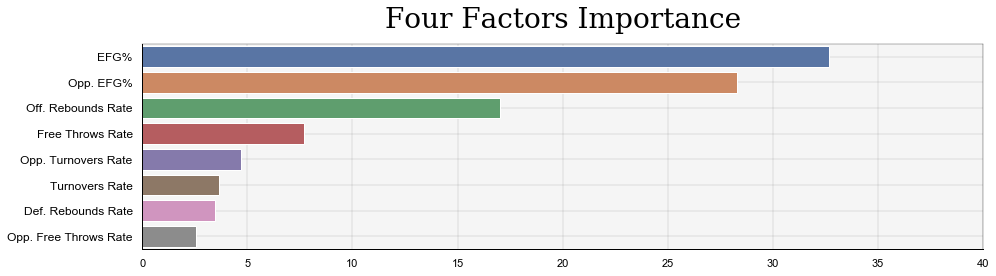

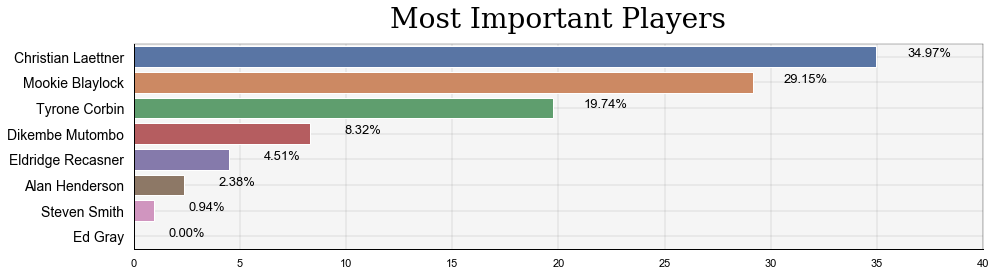

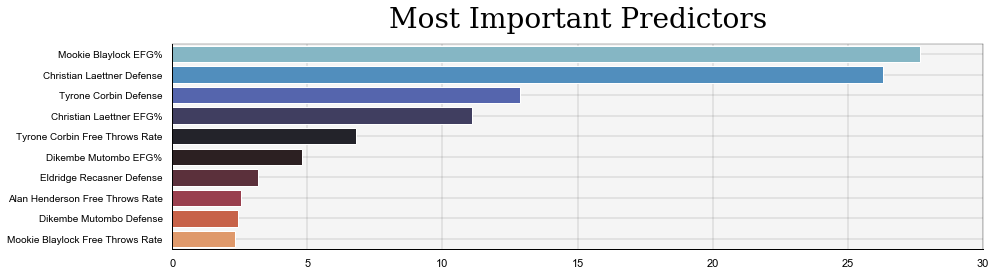

In [109]:
summarize_everything('ATL', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:07<00:00,  7.99trial/s, best loss: -0.9139705882352942]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 62.7                          50.3
1   Rebounding                  3.2                          16.8
2    Turnovers                 20.3                          20.7
3  Free Throws                 13.8                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.66trial/s, best loss: -0.8286764705882353]


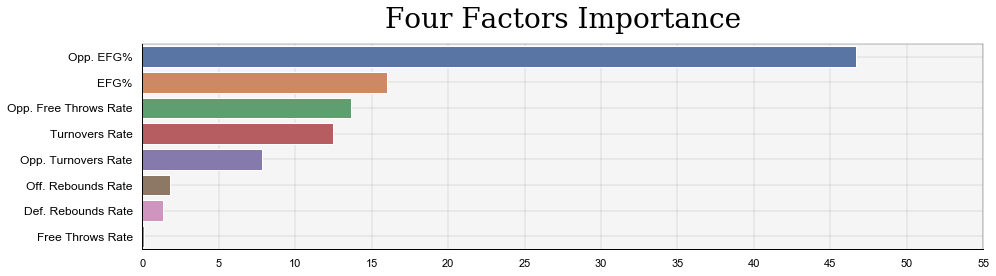

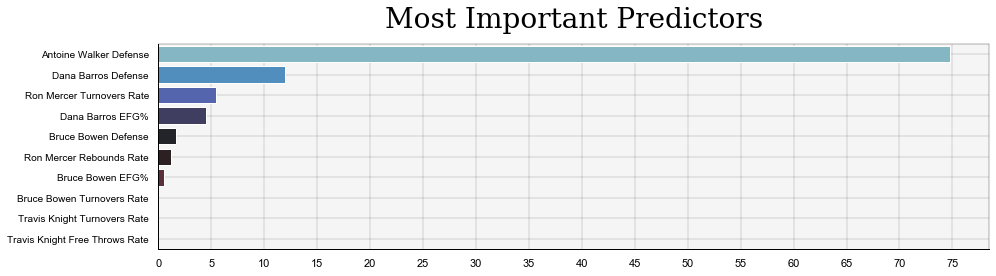

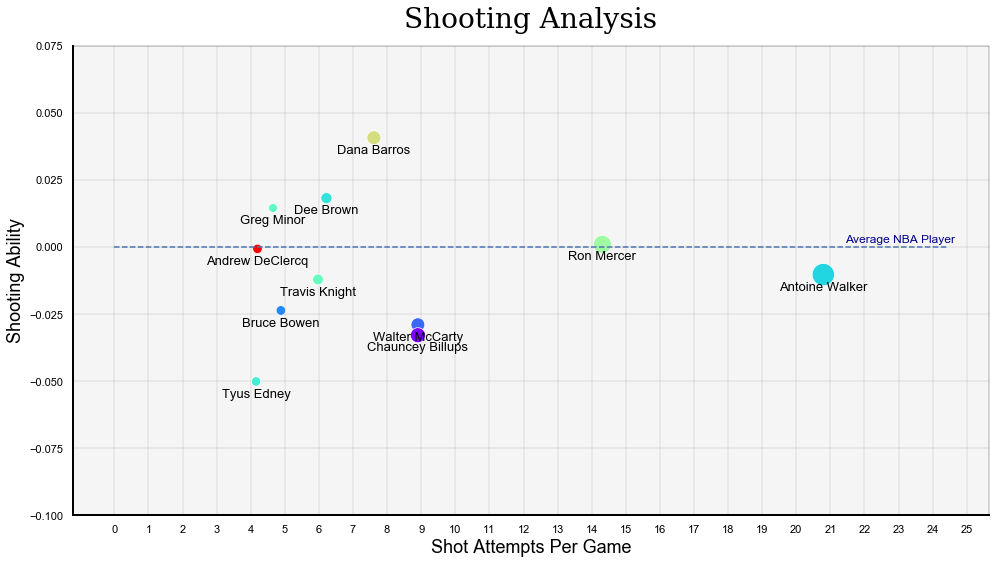

In [110]:
summarize_everything('BOS', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:07<00:00,  8.22trial/s, best loss: -0.7894736842105263]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 62.0                          50.3
1   Rebounding                 16.7                          16.8
2    Turnovers                 13.1                          20.7
3  Free Throws                  8.2                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  7.42trial/s, best loss: -0.7690058479532164]


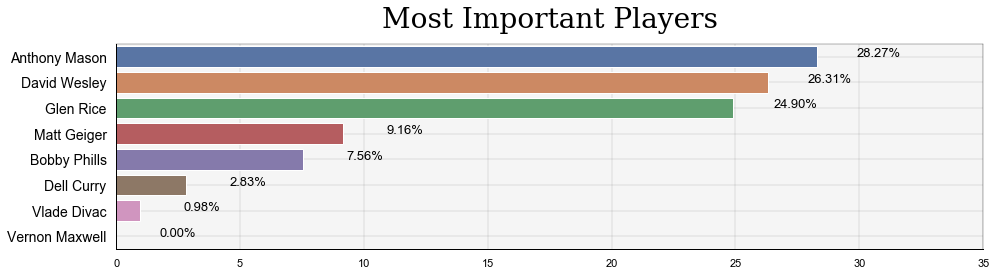

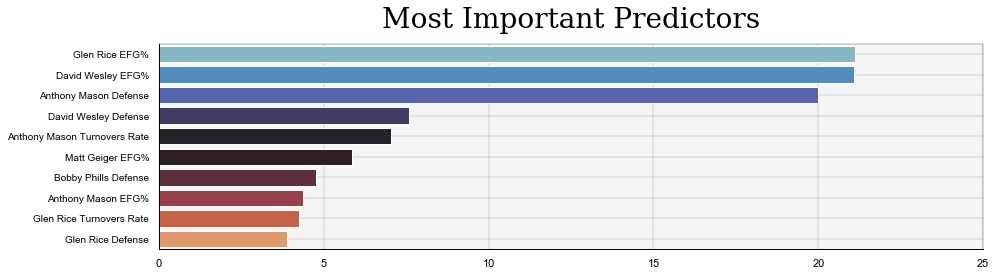

In [111]:
summarize_everything('CHH', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:07<00:00,  7.81trial/s, best loss: -0.8557142857142856]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 61.7                          50.3
1   Rebounding                 10.6                          16.8
2    Turnovers                 14.2                          20.7
3  Free Throws                 13.5                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.20trial/s, best loss: -0.8342857142857142]


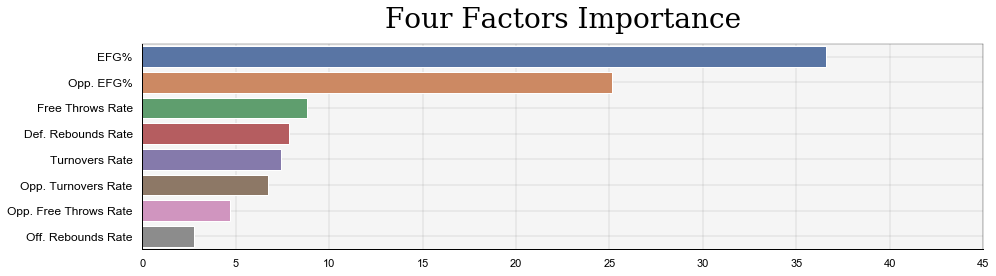

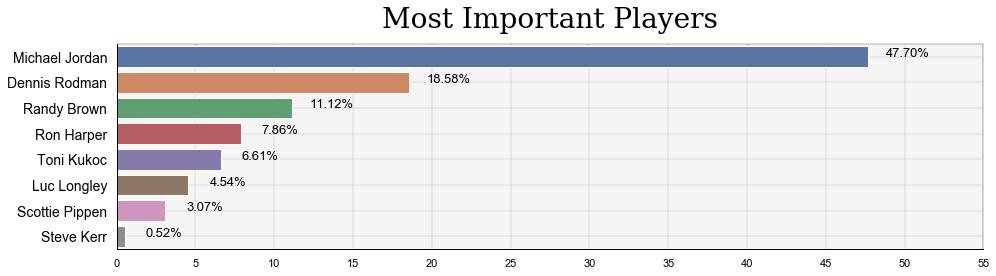

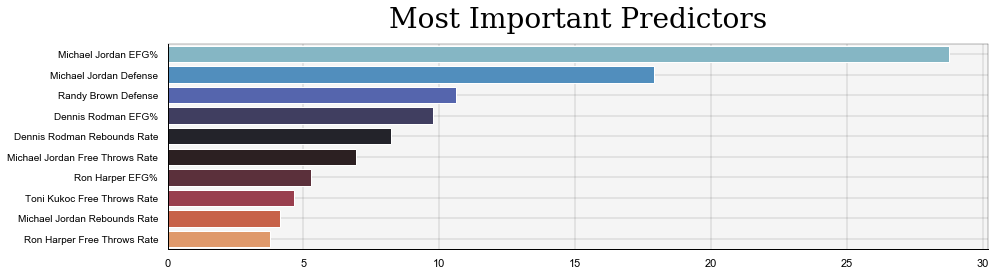

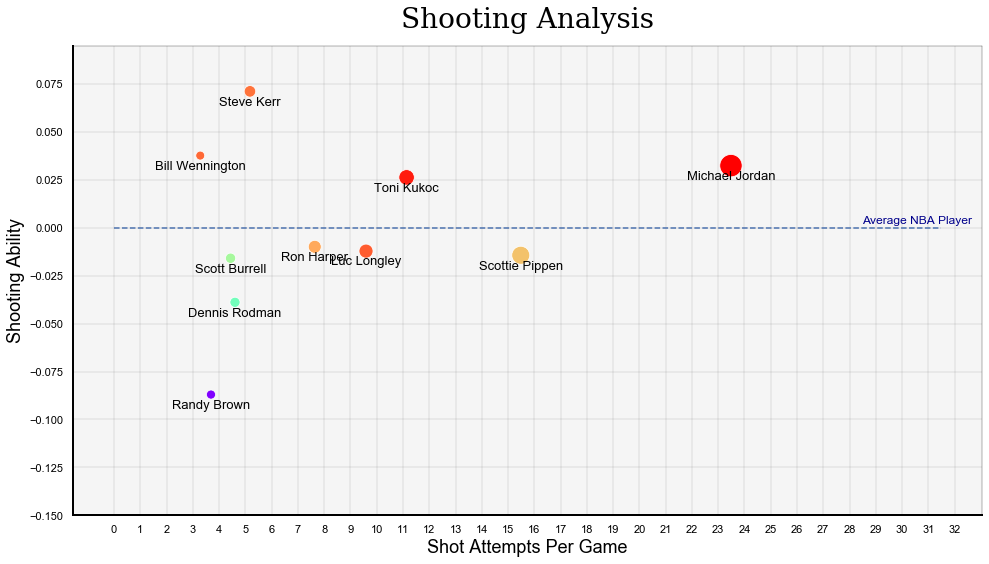

In [112]:
summarize_everything('CHI', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.70trial/s, best loss: -0.7888888888888889]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 68.9                          50.3
1   Rebounding                  7.1                          16.8
2    Turnovers                 13.3                          20.7
3  Free Throws                 10.7                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:10<00:00,  5.80trial/s, best loss: -0.8026143790849674]


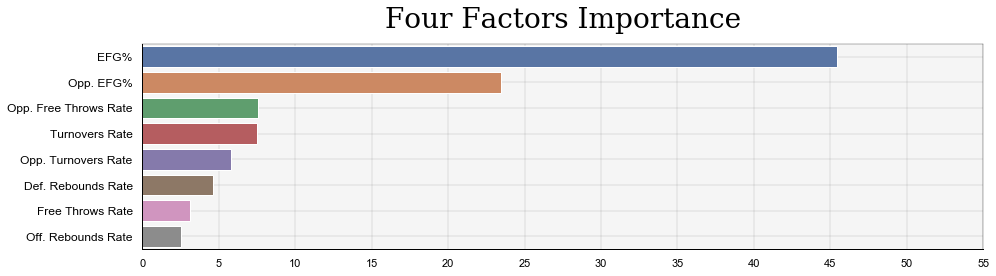

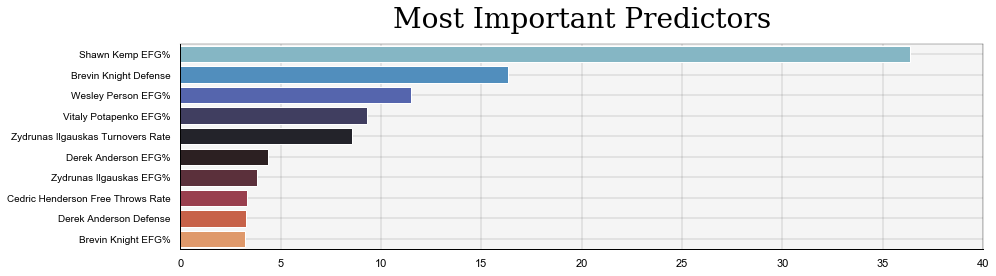

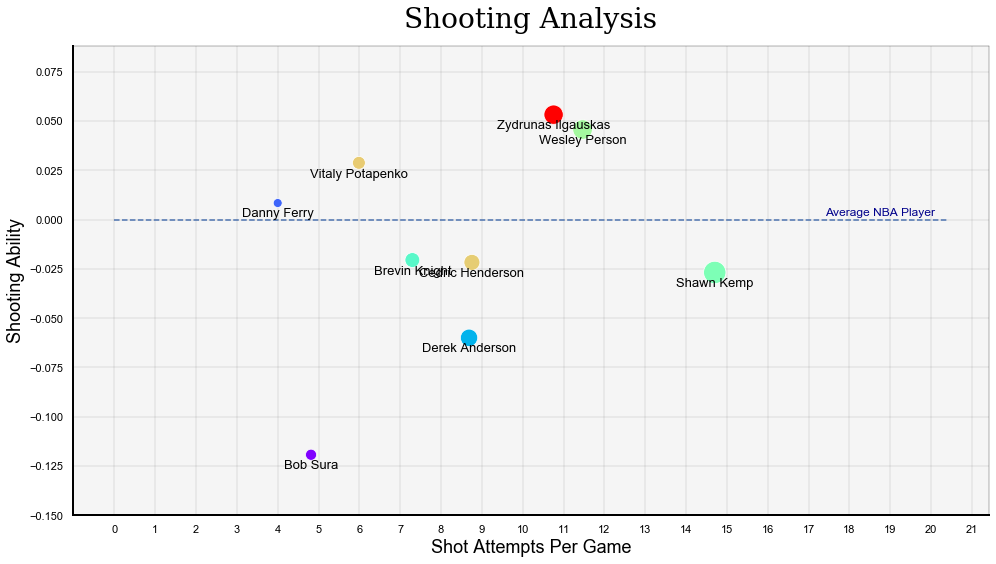

In [113]:
summarize_everything('CLE', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.39trial/s, best loss: -0.8919117647058823]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 51.1                          50.3
1   Rebounding                 22.3                          16.8
2    Turnovers                 16.3                          20.7
3  Free Throws                 10.2                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:10<00:00,  5.92trial/s, best loss: -0.8544117647058822]


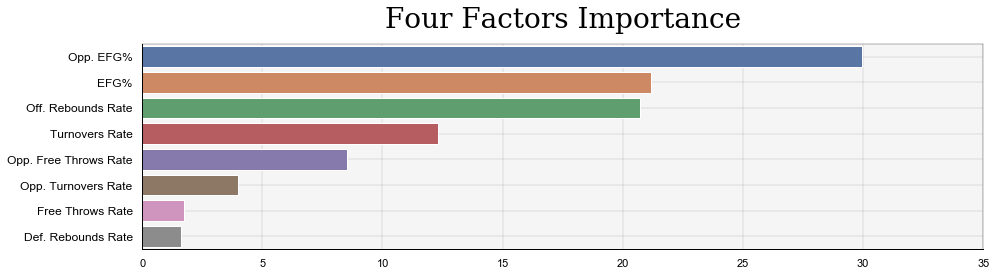

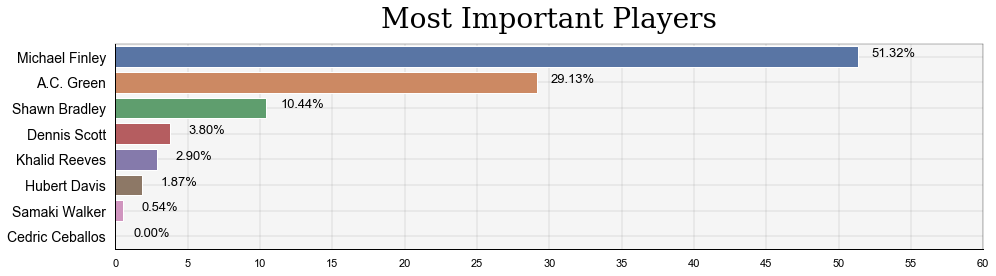

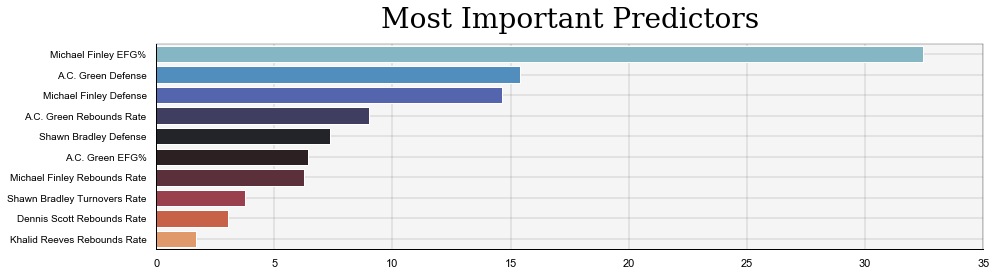

In [114]:
summarize_everything('DAL', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.17trial/s, best loss: -0.9036764705882353]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 43.7                          50.3
1   Rebounding                  5.9                          16.8
2    Turnovers                 14.6                          20.7
3  Free Throws                 35.8                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.39trial/s, best loss: -0.9154411764705882]


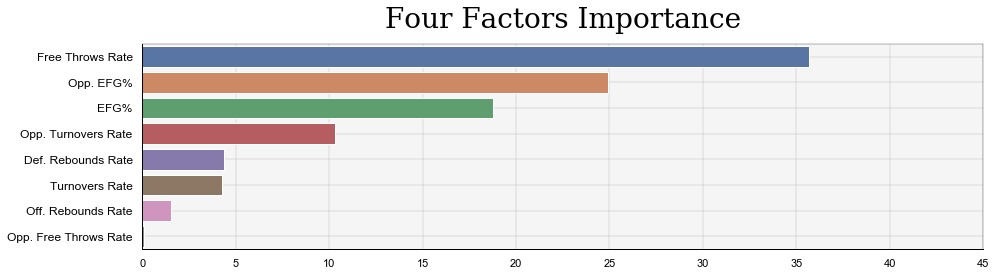

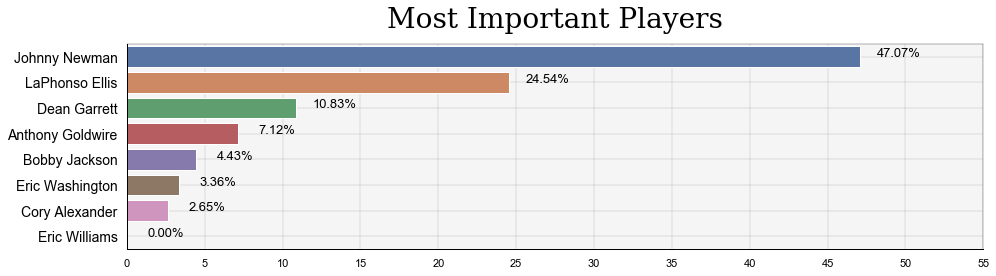

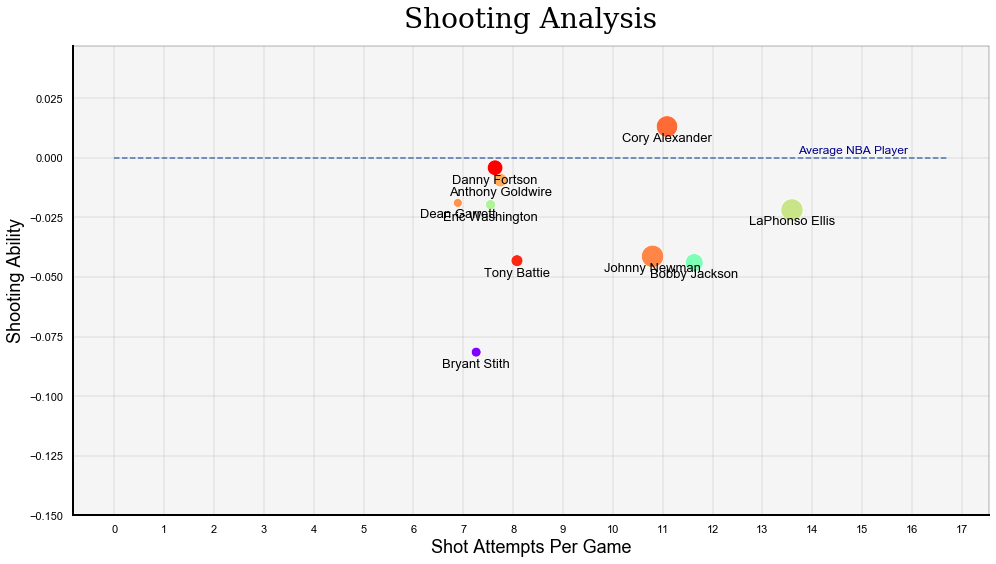

In [115]:
summarize_everything('DEN', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.38trial/s, best loss: -0.7536764705882353]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 63.3                          50.3
1   Rebounding                 15.2                          16.8
2    Turnovers                  8.7                          20.7
3  Free Throws                 12.7                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.43trial/s, best loss: -0.7816176470588235]


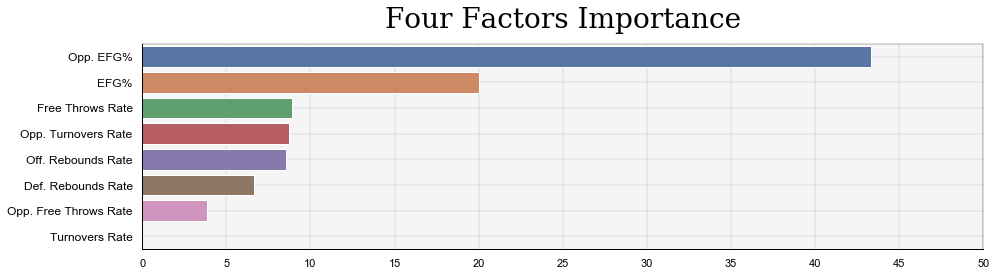

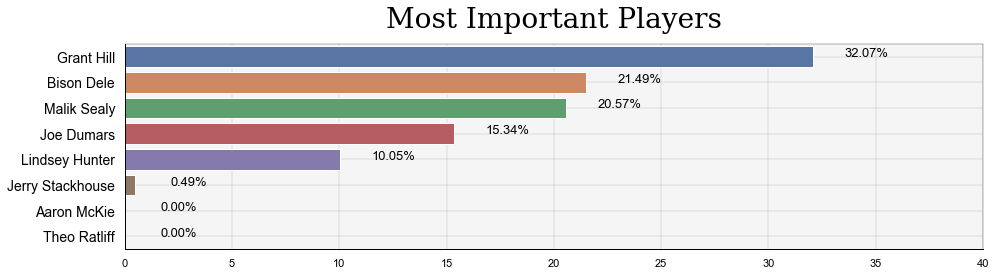

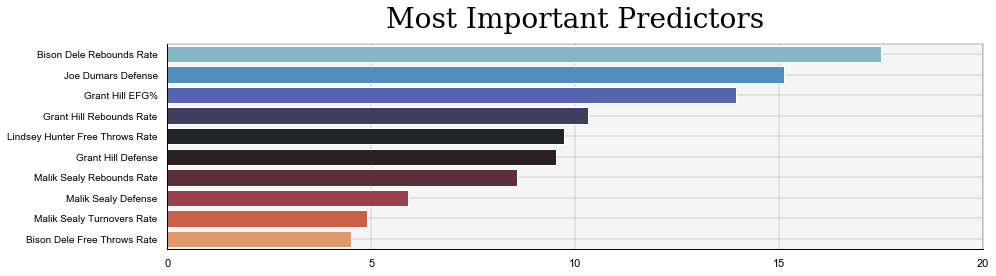

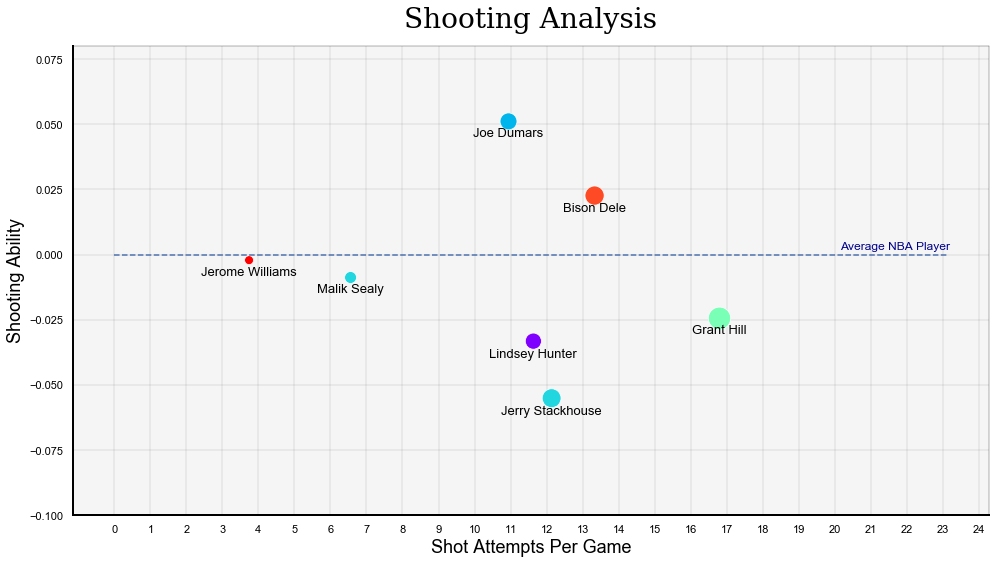

In [116]:
summarize_everything('DET', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  7.04trial/s, best loss: -0.8904411764705882]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 53.8                          50.3
1   Rebounding                  0.8                          16.8
2    Turnovers                 22.9                          20.7
3  Free Throws                 22.5                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.48trial/s, best loss: -0.8522058823529411]


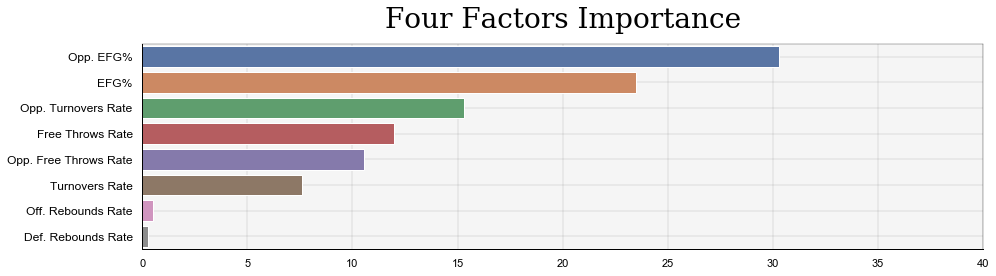

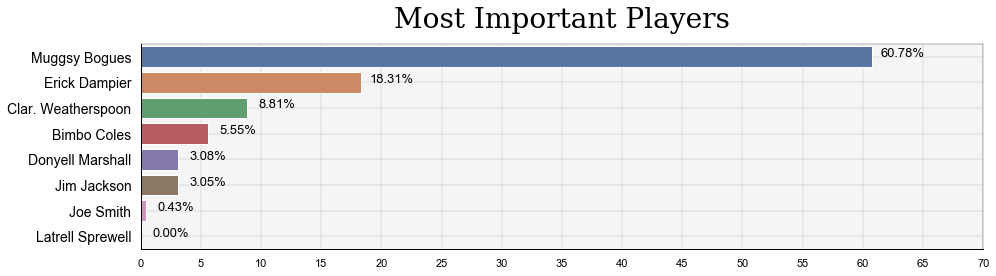

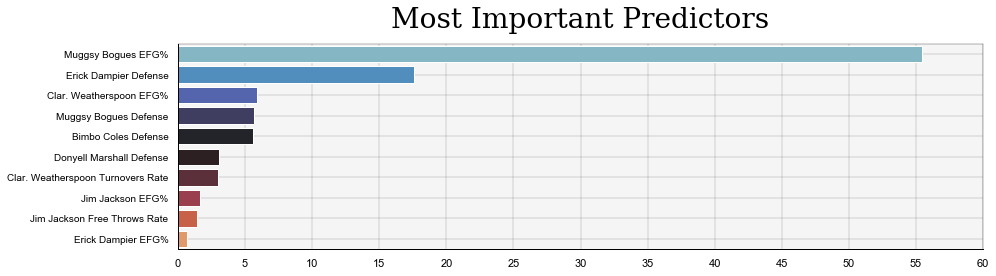

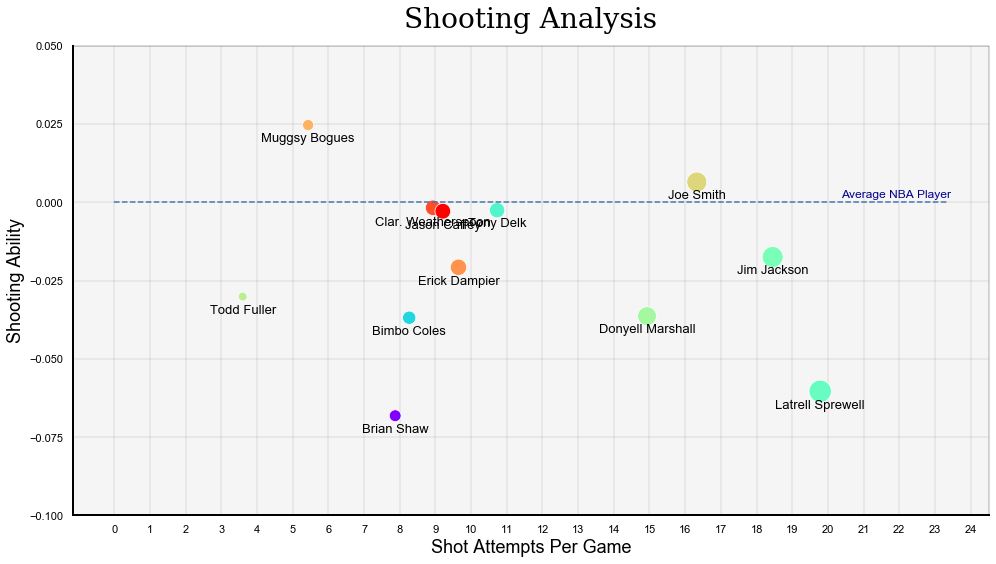

In [117]:
summarize_everything('GSW', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.62trial/s, best loss: -0.8594771241830065]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 60.7                          50.3
1   Rebounding                 20.8                          16.8
2    Turnovers                 12.0                          20.7
3  Free Throws                  6.5                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.38trial/s, best loss: -0.7941176470588236]


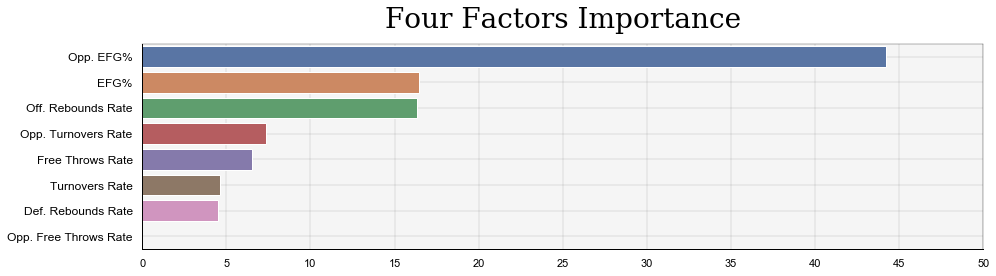

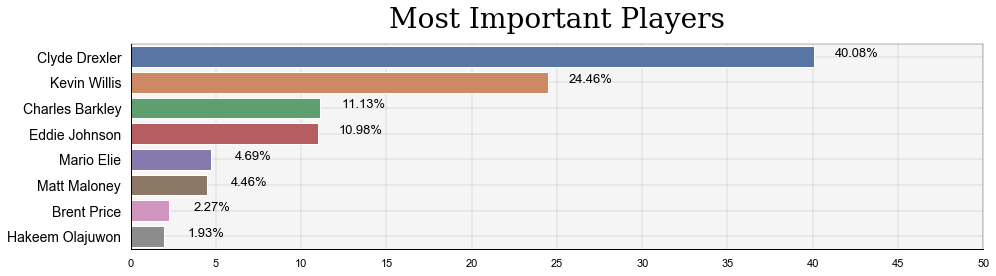

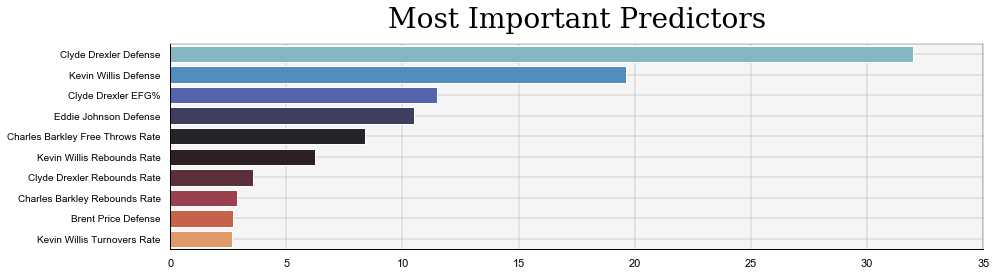

In [118]:
summarize_everything('HOU', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.71trial/s, best loss: -0.8073684210526315]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 49.2                          50.3
1   Rebounding                 19.2                          16.8
2    Turnovers                 20.1                          20.7
3  Free Throws                 11.5                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.45trial/s, best loss: -0.7763157894736843]


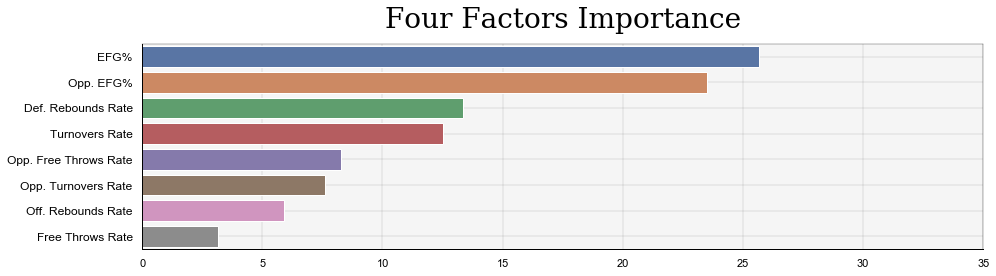

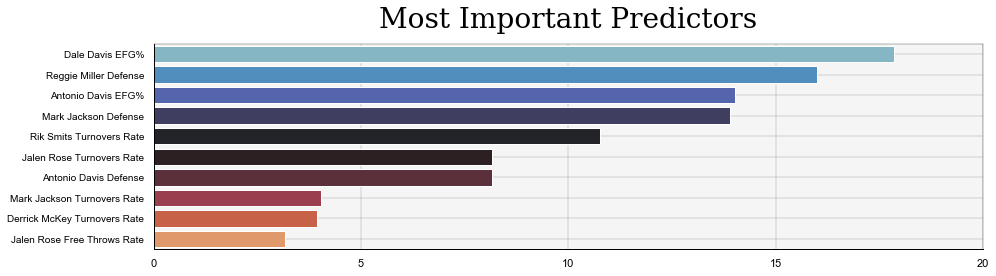

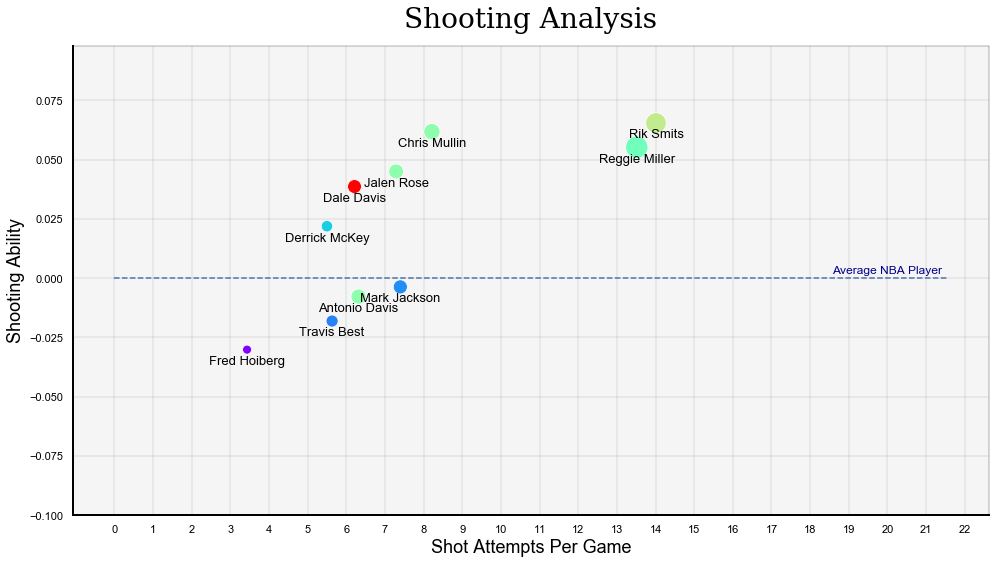

In [119]:
summarize_everything('IND', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.99trial/s, best loss: -0.8426470588235293]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 41.5                          50.3
1   Rebounding                  8.9                          16.8
2    Turnovers                 38.0                          20.7
3  Free Throws                 11.6                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.53trial/s, best loss: -0.8426470588235293]


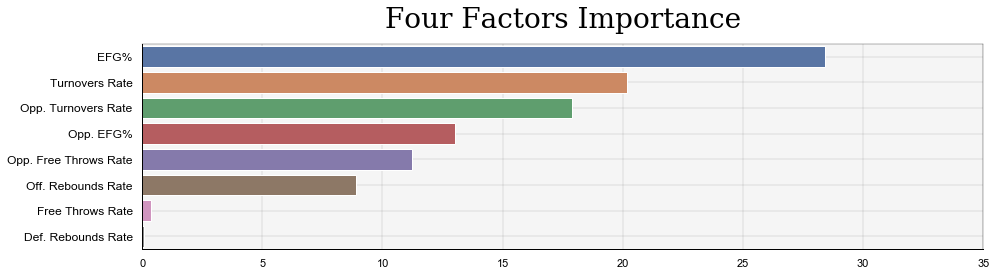

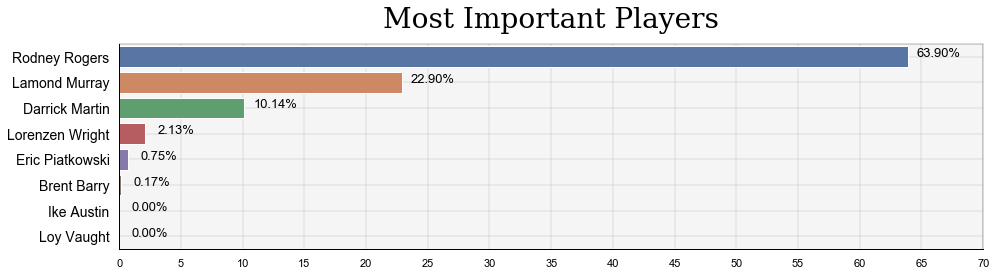

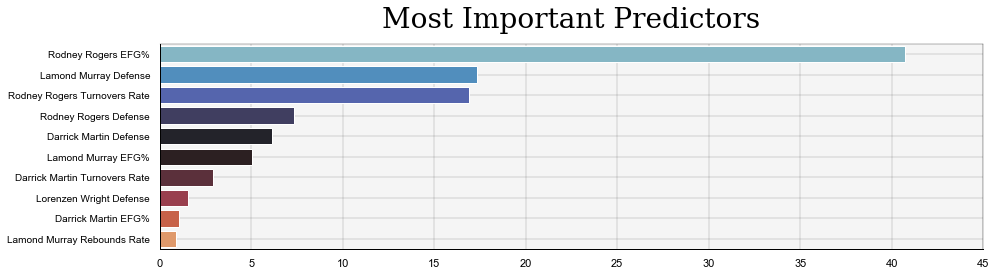

In [120]:
summarize_everything('LAC', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.86trial/s, best loss: -0.8631578947368421]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 56.4                          50.3
1   Rebounding                  8.6                          16.8
2    Turnovers                 11.7                          20.7
3  Free Throws                 23.4                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.49trial/s, best loss: -0.8315789473684211]


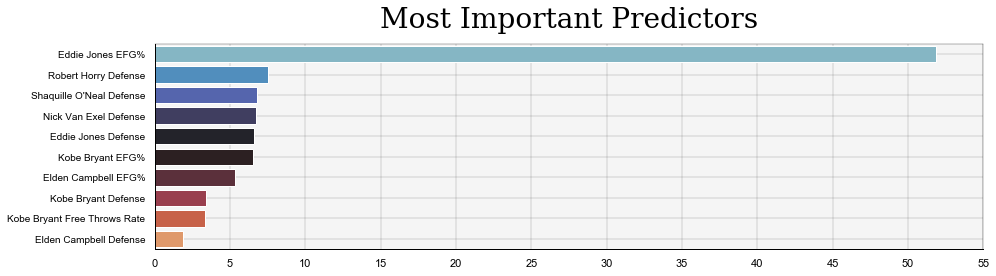

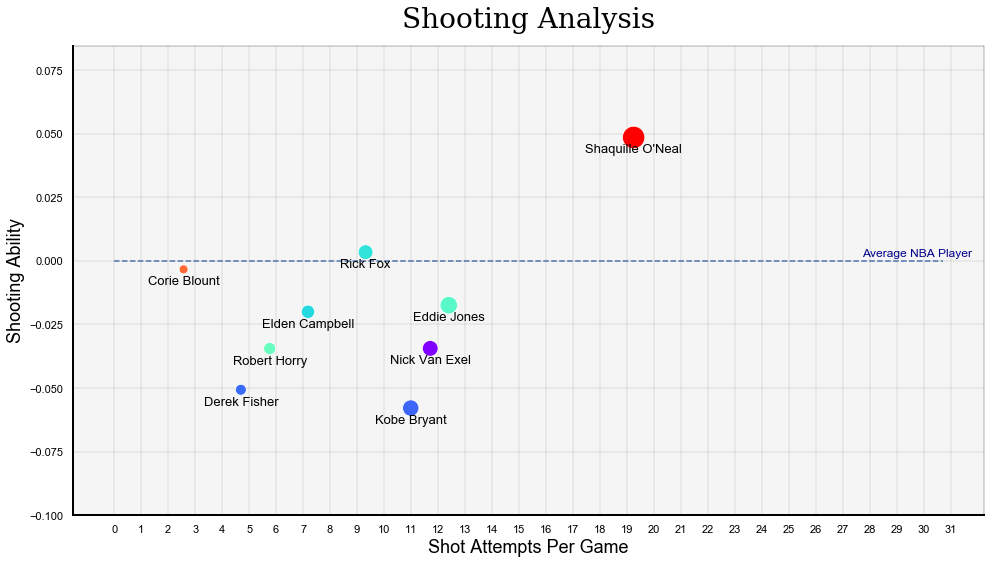

In [121]:
summarize_everything('LAL', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.96trial/s, best loss: -0.8620915032679738]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 63.0                          50.3
1   Rebounding                  9.2                          16.8
2    Turnovers                 17.7                          20.7
3  Free Throws                 10.1                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.14trial/s, best loss: -0.8522875816993464]


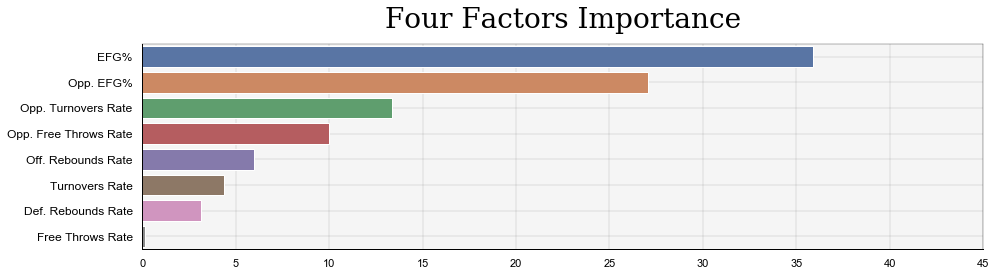

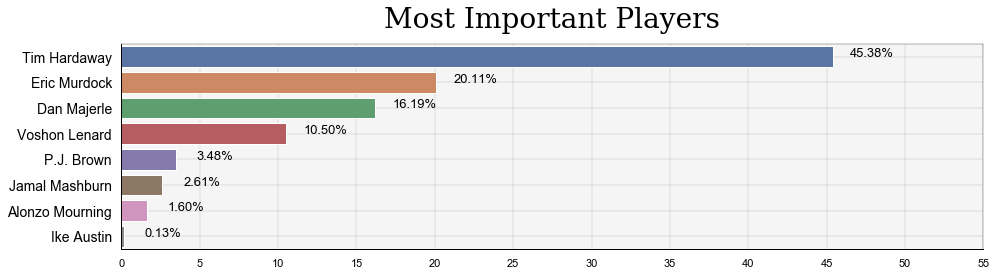

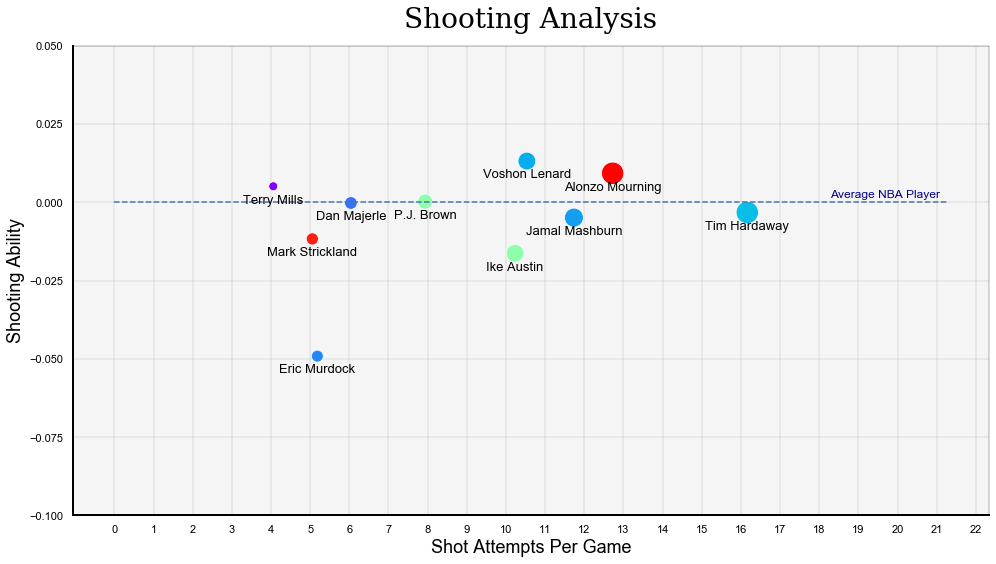

In [122]:
summarize_everything('MIA', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.42trial/s, best loss: -0.8066176470588236]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 59.8                          50.3
1   Rebounding                  9.0                          16.8
2    Turnovers                 19.1                          20.7
3  Free Throws                 12.1                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.46trial/s, best loss: -0.7588235294117647]


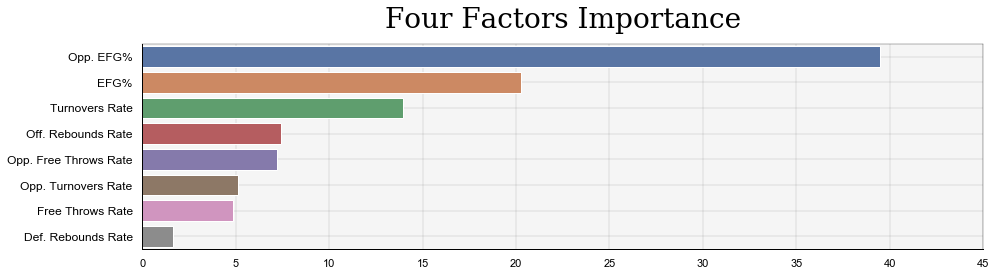

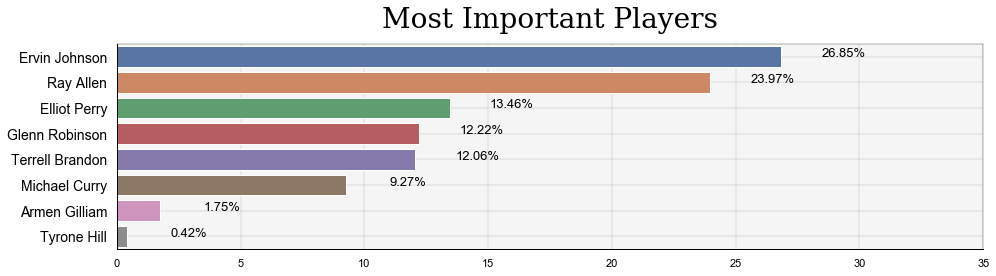

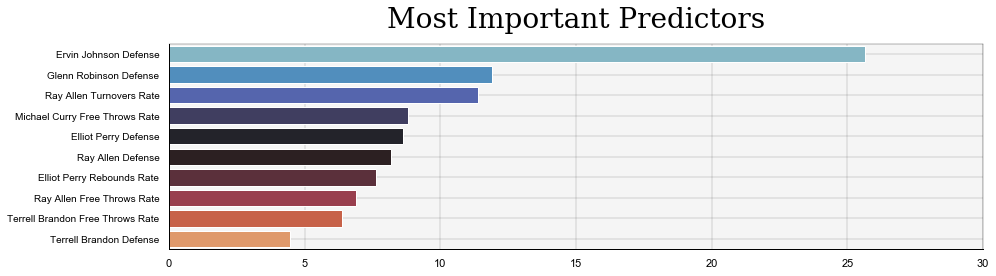

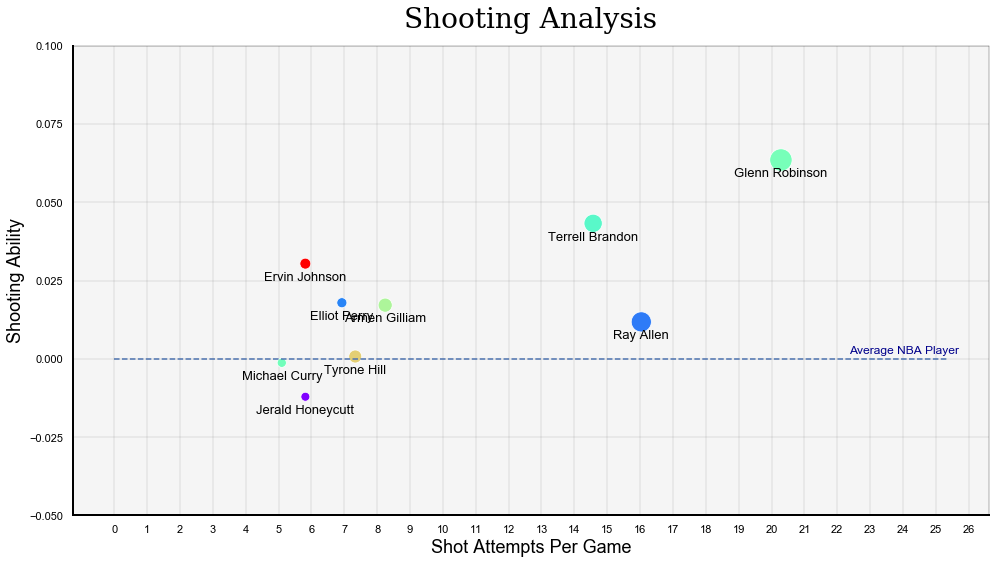

In [123]:
summarize_everything('MIL', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.49trial/s, best loss: -0.7954248366013073]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 59.5                          50.3
1   Rebounding                  8.8                          16.8
2    Turnovers                 19.4                          20.7
3  Free Throws                 12.3                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.39trial/s, best loss: -0.7477124183006536]


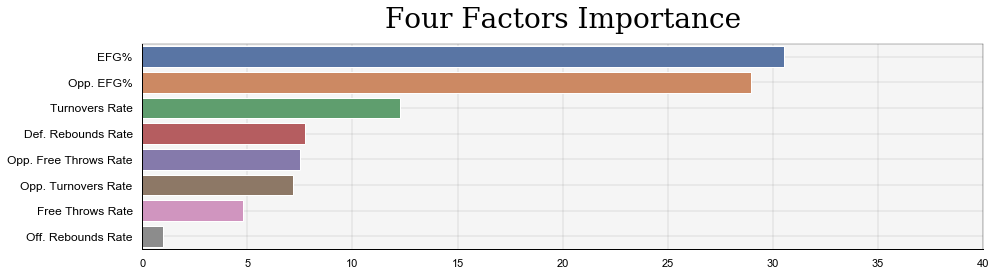

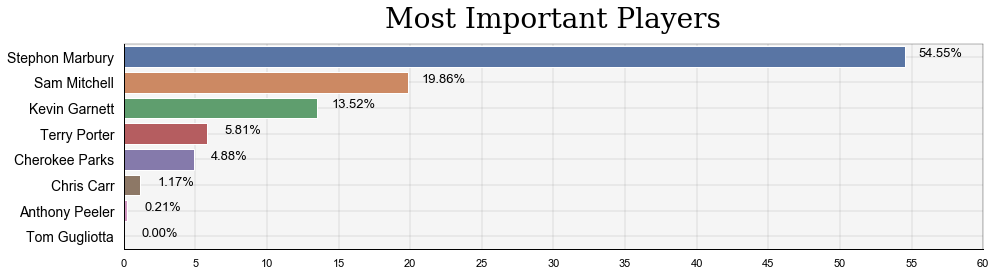

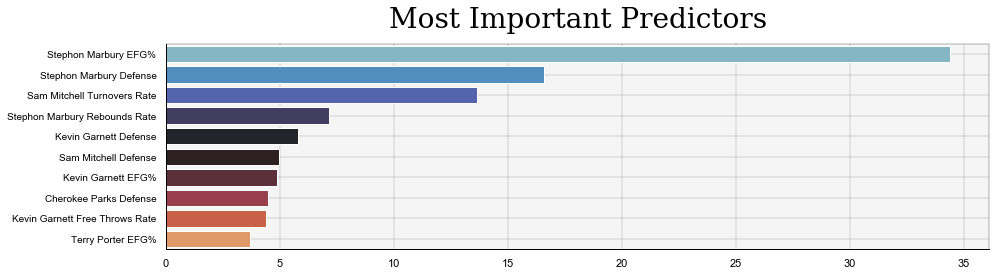

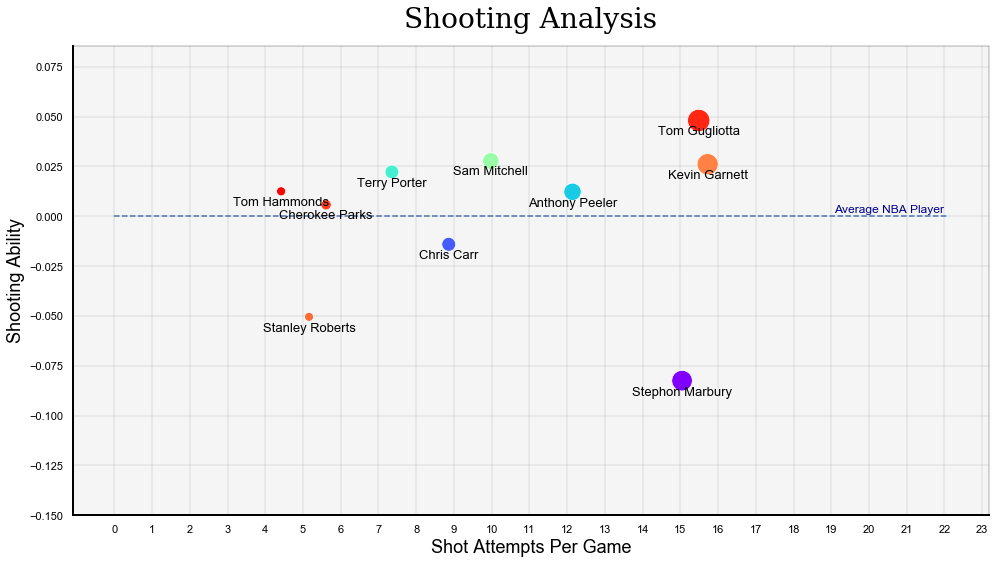

In [124]:
summarize_everything('MIN', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:10<00:00,  5.99trial/s, best loss: -0.7294117647058822]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 46.3                          50.3
1   Rebounding                 17.9                          16.8
2    Turnovers                 14.2                          20.7
3  Free Throws                 21.6                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.07trial/s, best loss: -0.6235294117647059]


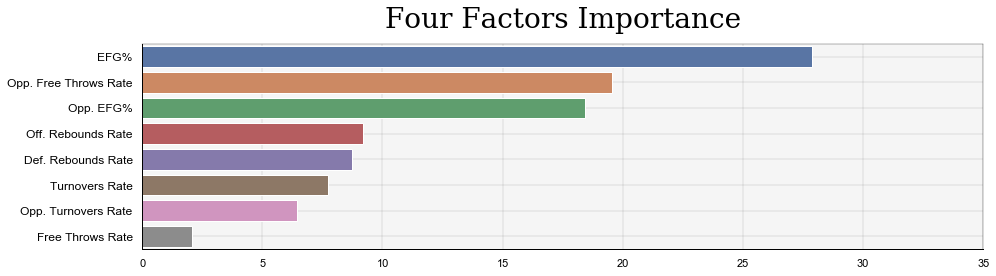

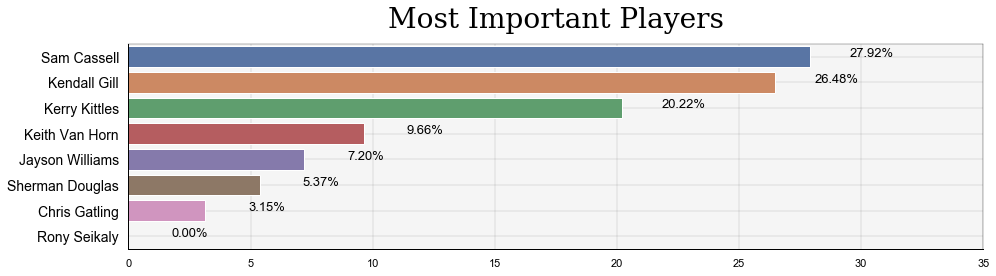

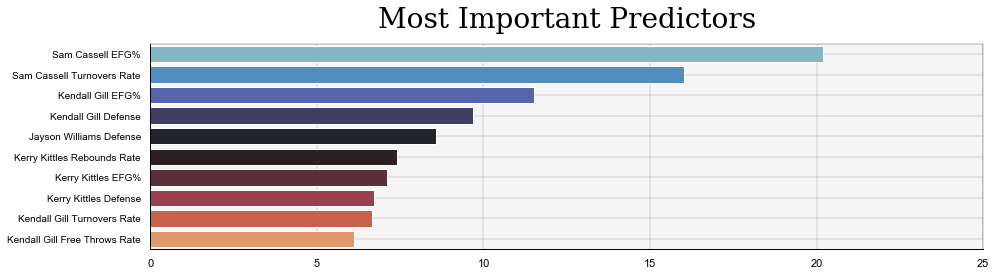

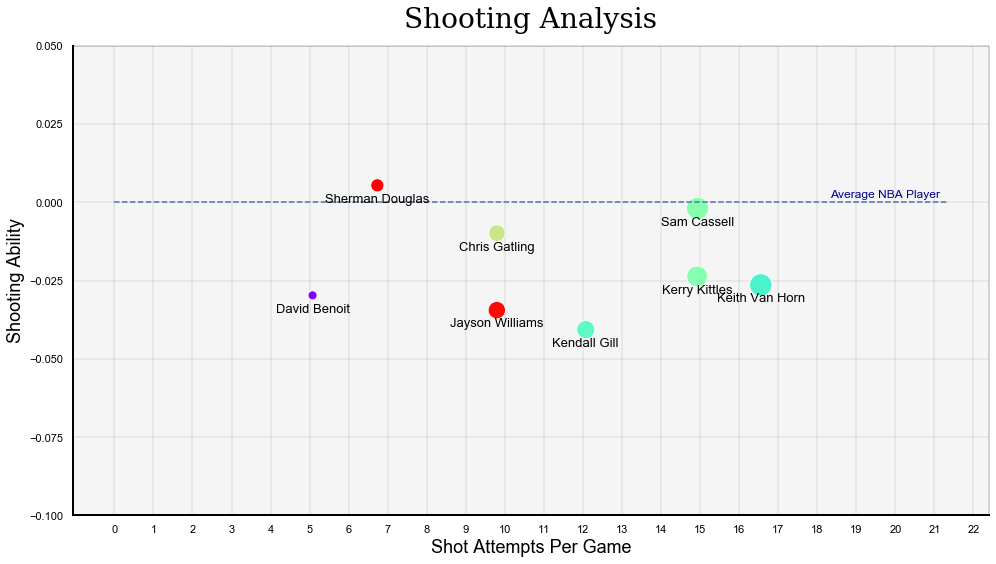

In [125]:
summarize_everything('NJN', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.67trial/s, best loss: -0.8163742690058479]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 56.4                          50.3
1   Rebounding                 15.7                          16.8
2    Turnovers                 17.0                          20.7
3  Free Throws                 10.9                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.45trial/s, best loss: -0.7842105263157895]


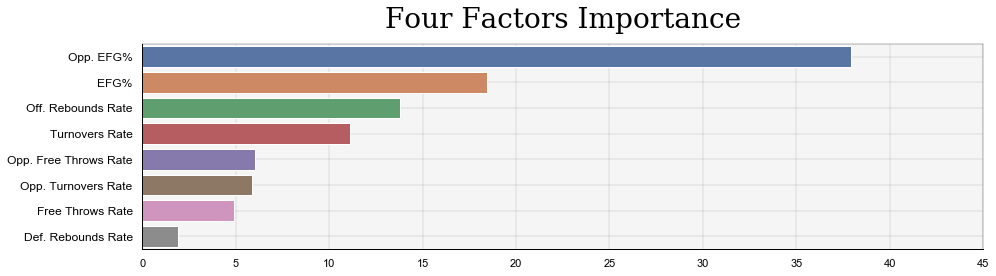

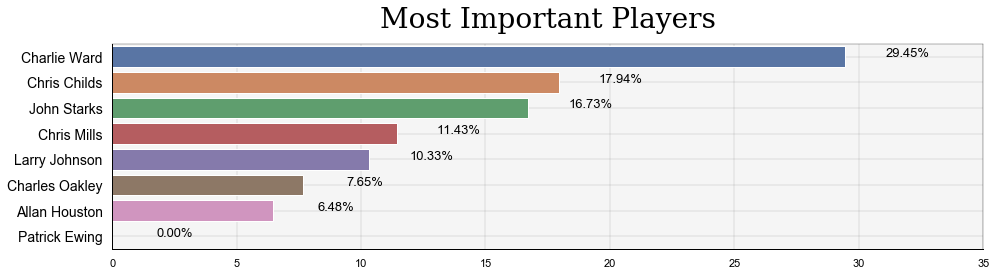

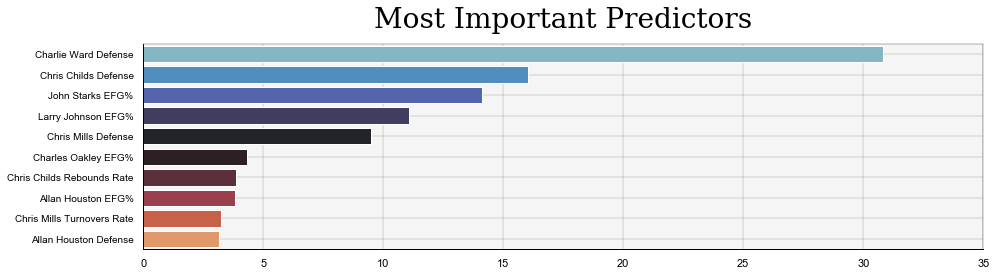

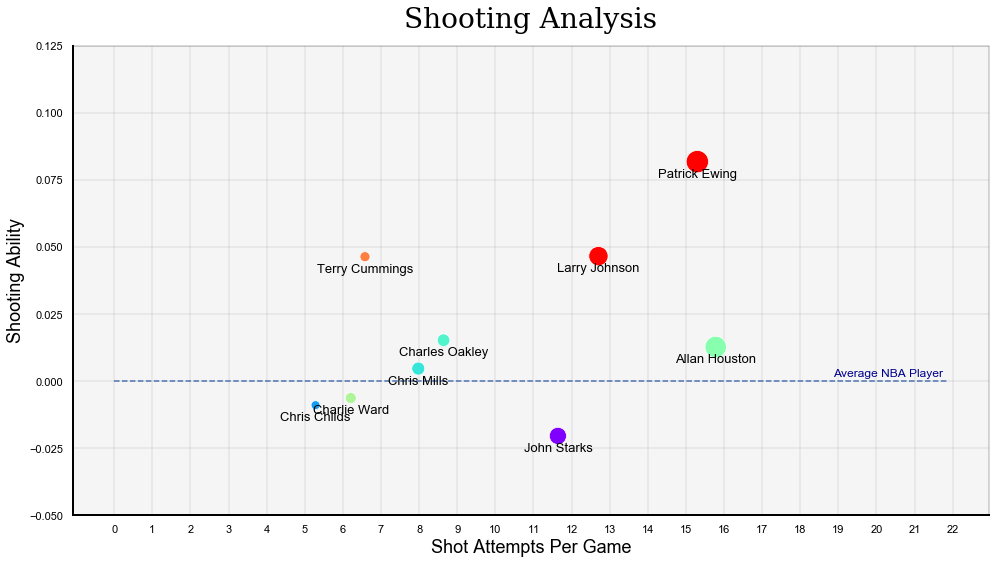

In [126]:
summarize_everything('NYK', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  7.07trial/s, best loss: -0.8779411764705882]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 60.0                          50.3
1   Rebounding                 17.2                          16.8
2    Turnovers                 10.3                          20.7
3  Free Throws                 12.5                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.63trial/s, best loss: -0.7683823529411764]


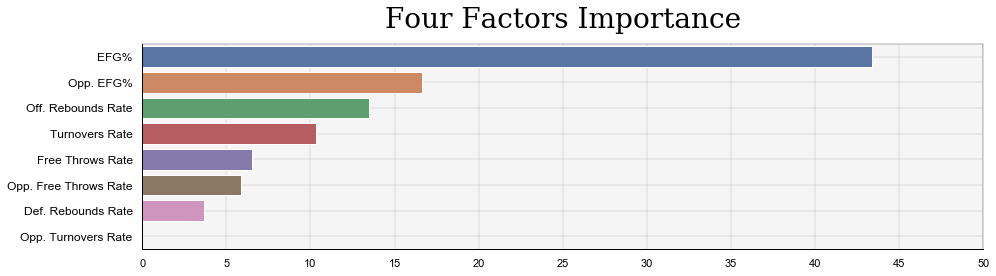

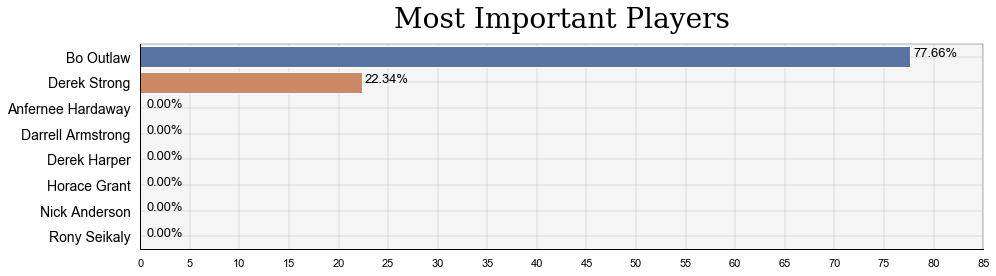

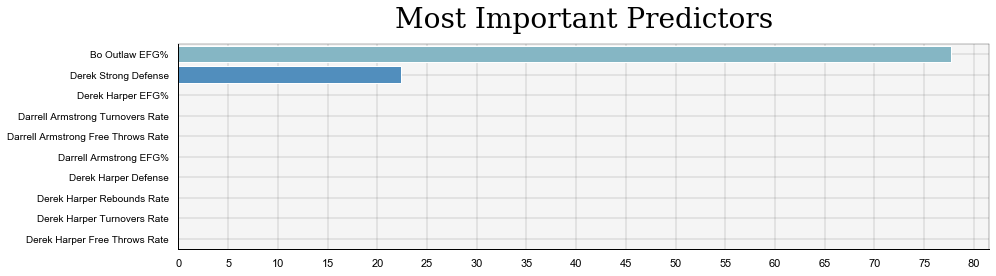

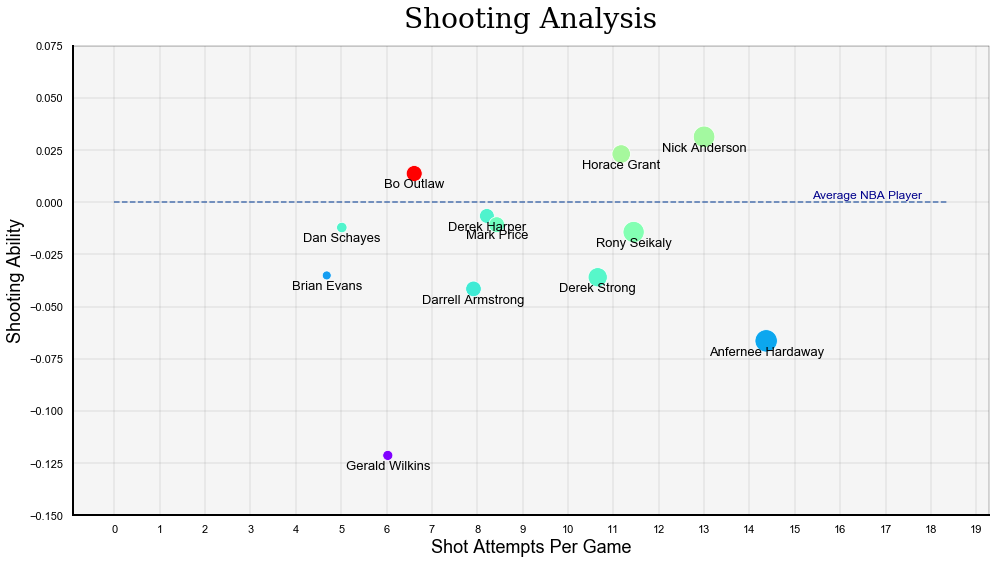

In [127]:
summarize_everything('ORL', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  7.04trial/s, best loss: -0.8029411764705883]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 48.3                          50.3
1   Rebounding                 15.0                          16.8
2    Turnovers                 25.8                          20.7
3  Free Throws                 10.9                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.61trial/s, best loss: -0.7926470588235294]


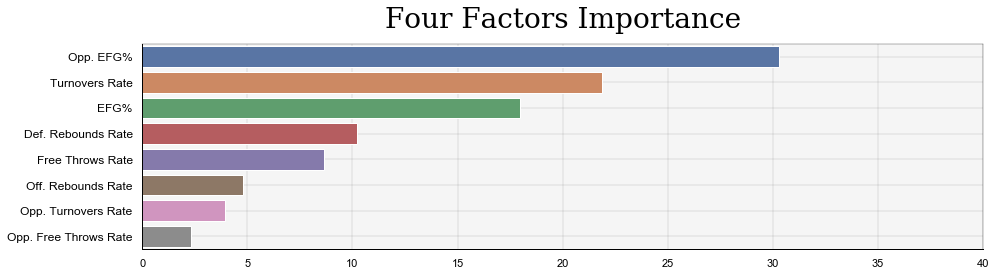

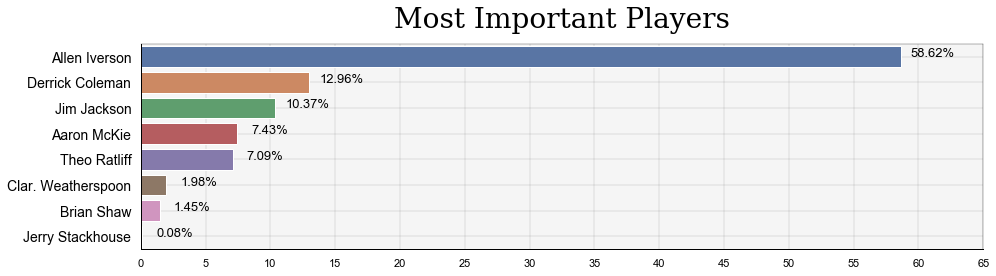

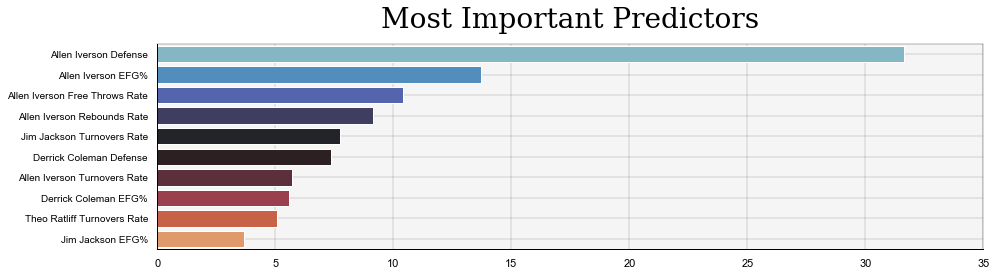

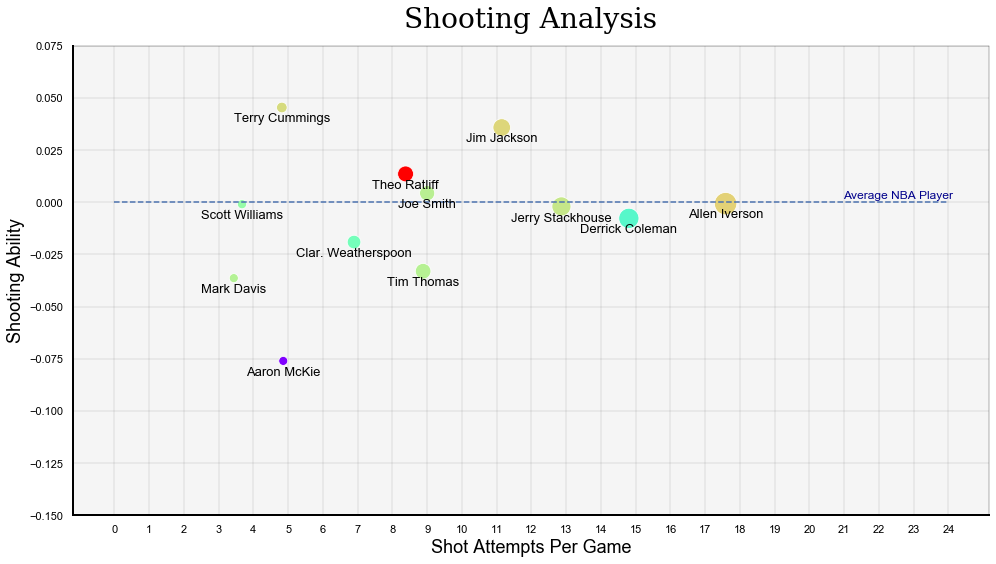

In [128]:
summarize_everything('PHI', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.99trial/s, best loss: -0.8607843137254901]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 49.5                          50.3
1   Rebounding                 10.9                          16.8
2    Turnovers                 21.1                          20.7
3  Free Throws                 18.5                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.24trial/s, best loss: -0.8254901960784313]


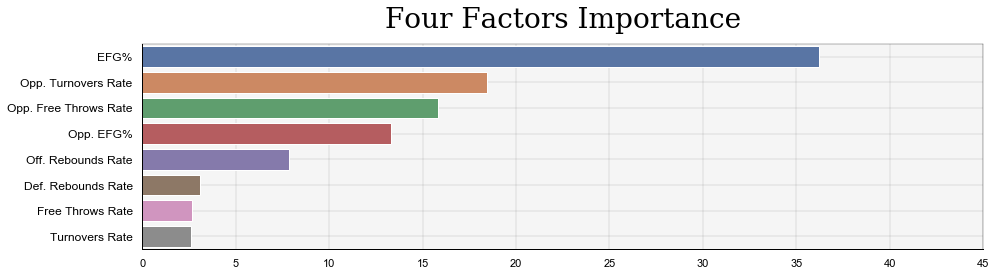

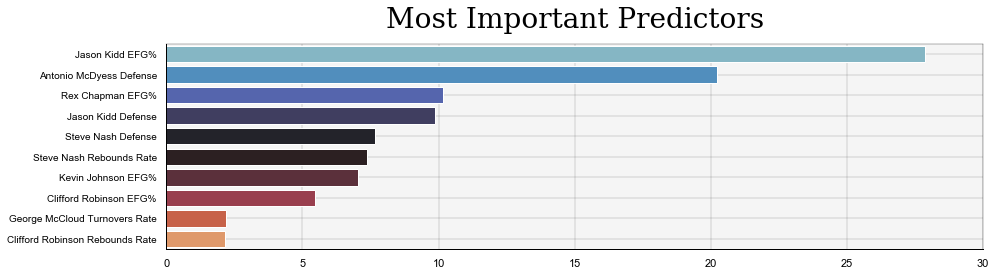

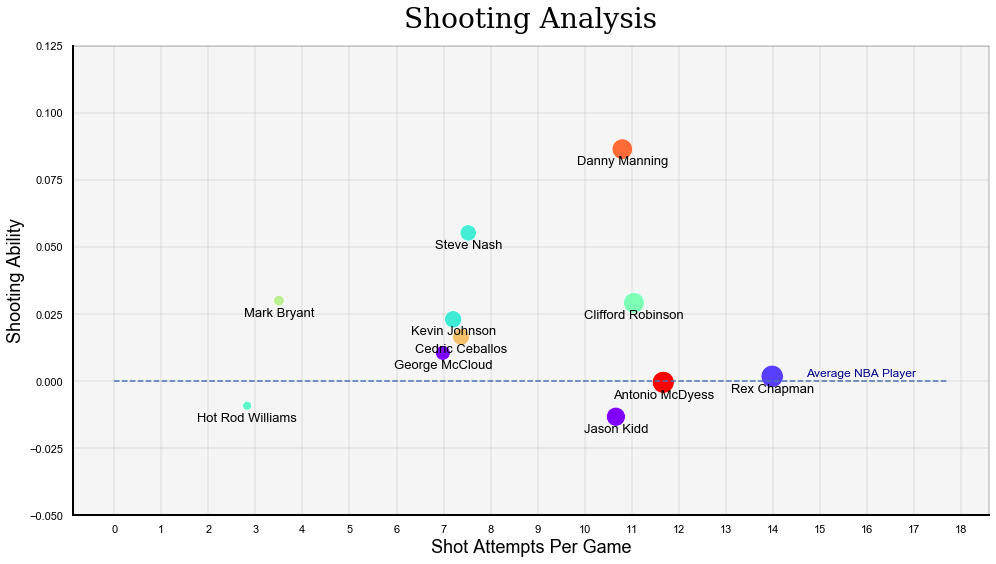

In [129]:
summarize_everything('PHX', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.56trial/s, best loss: -0.8019607843137255]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 64.5                          50.3
1   Rebounding                 15.0                          16.8
2    Turnovers                  7.3                          20.7
3  Free Throws                 13.2                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.51trial/s, best loss: -0.7431372549019607]


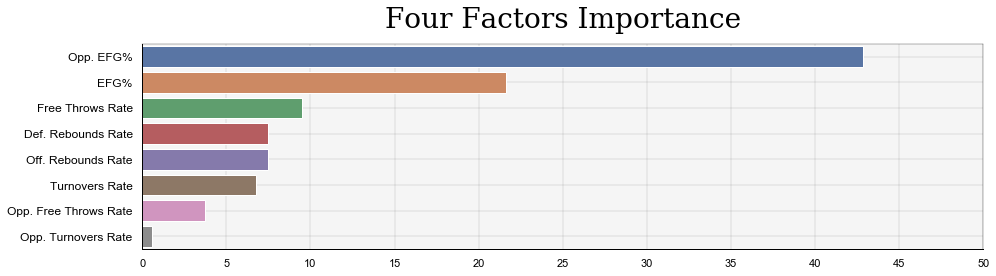

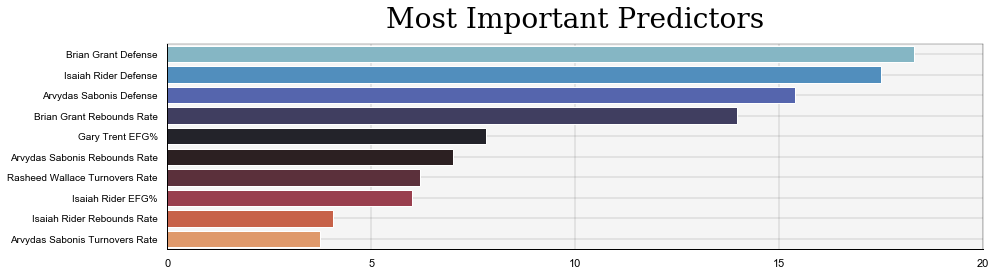

In [130]:
summarize_everything('POR', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.99trial/s, best loss: -0.8419117647058822]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 54.7                          50.3
1   Rebounding                 22.1                          16.8
2    Turnovers                 14.9                          20.7
3  Free Throws                  8.3                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.39trial/s, best loss: -0.7933823529411764]


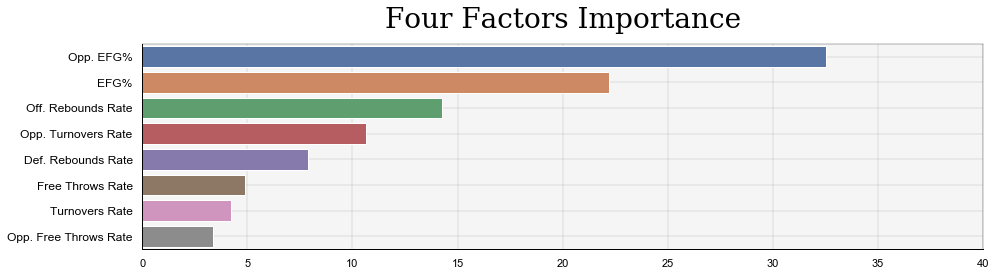

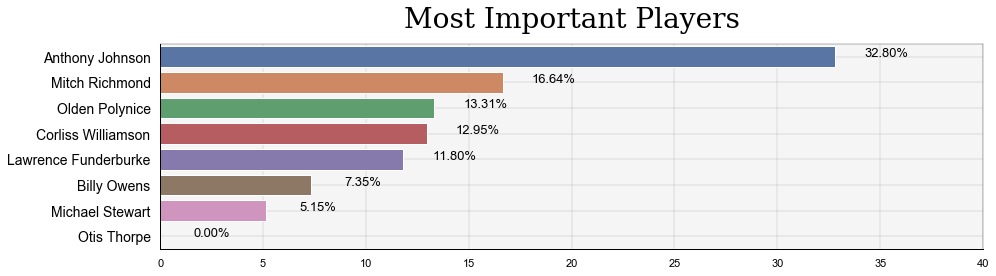

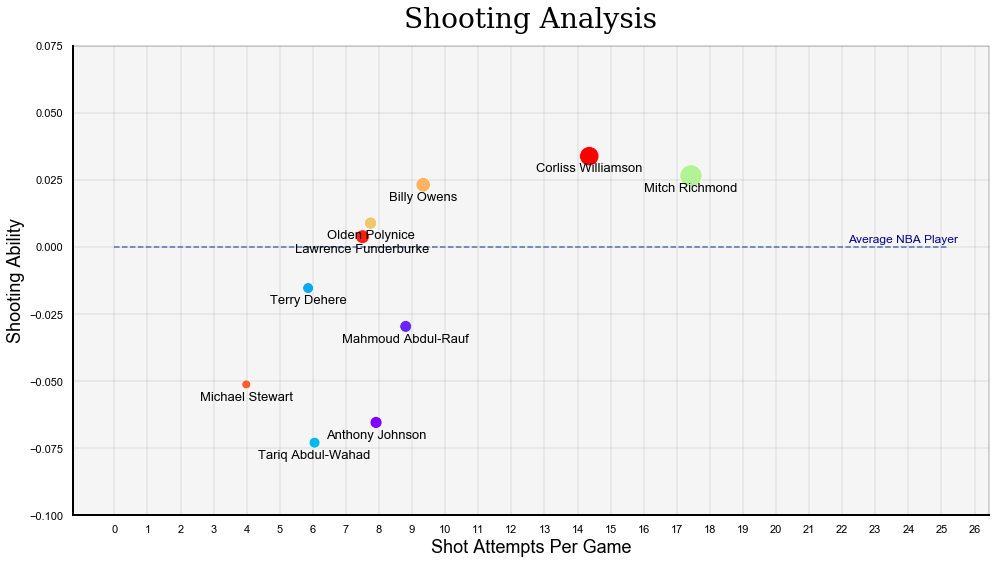

In [131]:
summarize_everything('SAC', '1997-98 Season')

100%|████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.83trial/s, best loss: -0.835672514619883]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 73.0                          50.3
1   Rebounding                 11.5                          16.8
2    Turnovers                  6.4                          20.7
3  Free Throws                  9.1                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.43trial/s, best loss: -0.8456140350877194]


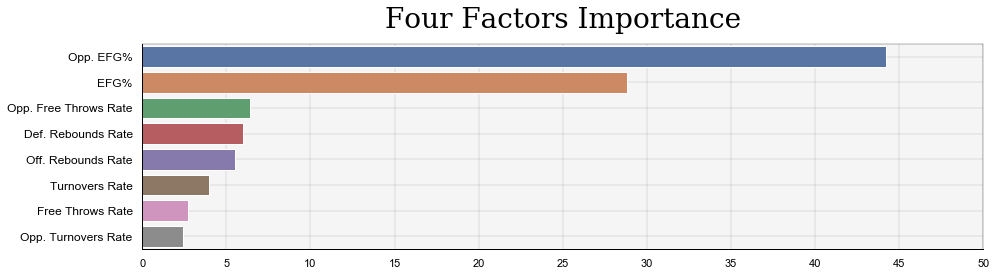

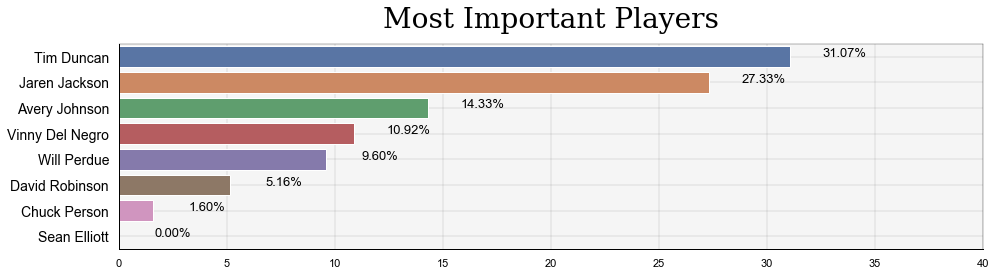

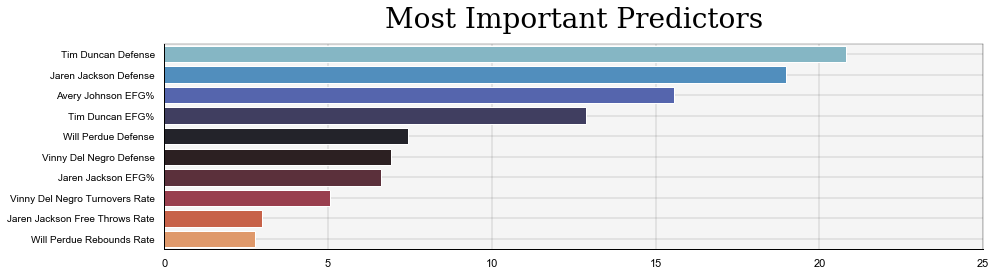

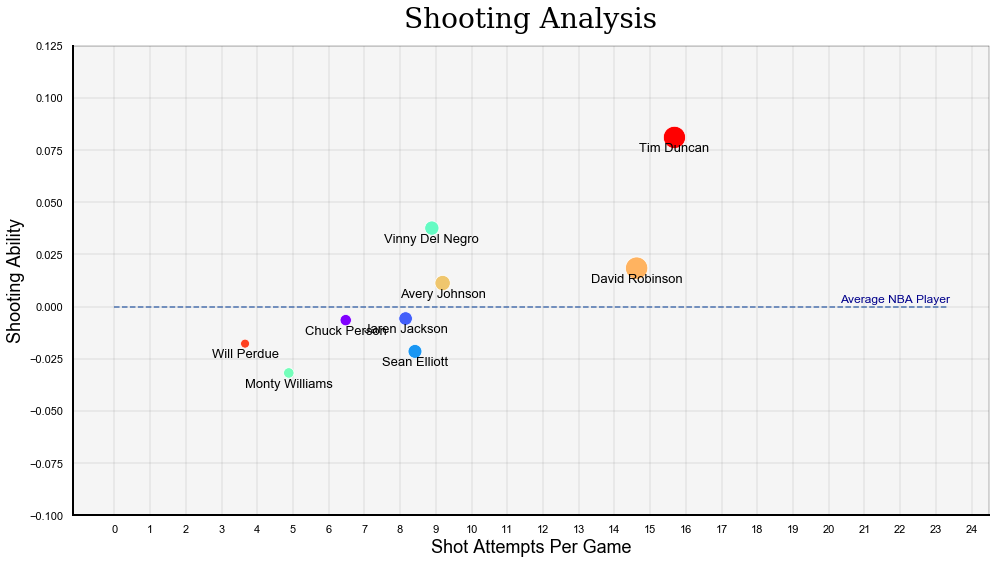

In [132]:
summarize_everything('SAS', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.79trial/s, best loss: -0.8269005847953217]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 47.6                          50.3
1   Rebounding                 14.9                          16.8
2    Turnovers                 24.9                          20.7
3  Free Throws                 12.6                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.44trial/s, best loss: -0.8169590643274853]


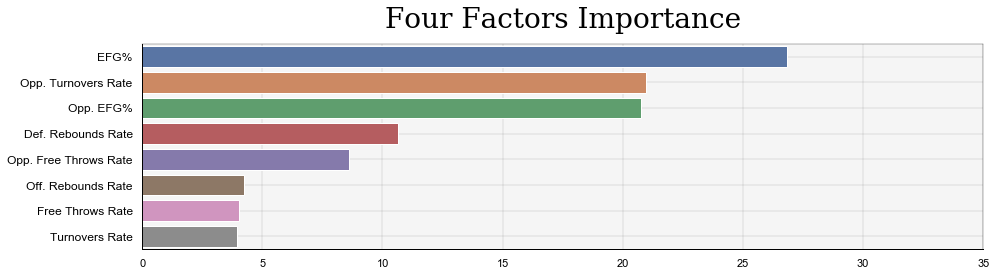

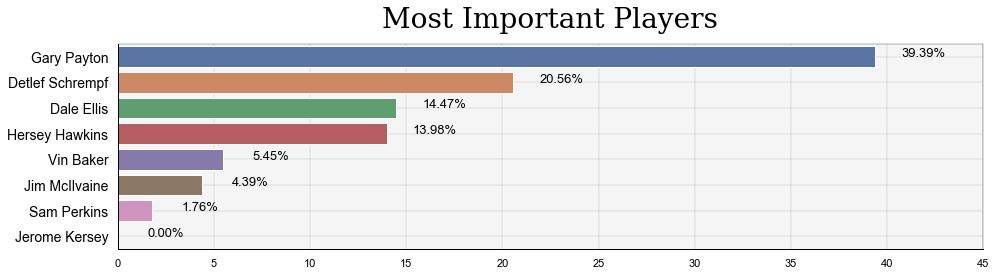

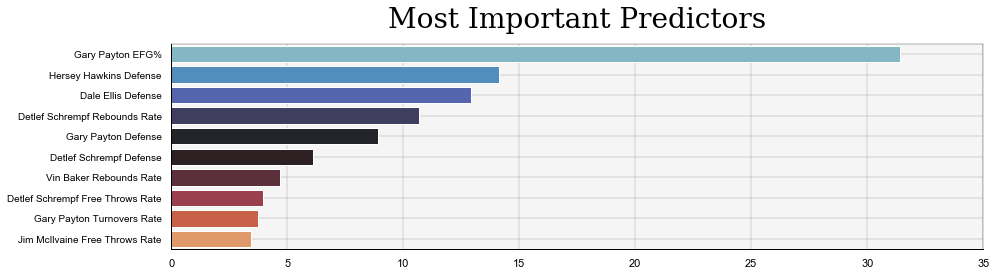

In [133]:
summarize_everything('SEA', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.89trial/s, best loss: -0.8426470588235293]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 66.8                          50.3
1   Rebounding                 12.1                          16.8
2    Turnovers                 13.1                          20.7
3  Free Throws                  7.9                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.52trial/s, best loss: -0.8794117647058822]


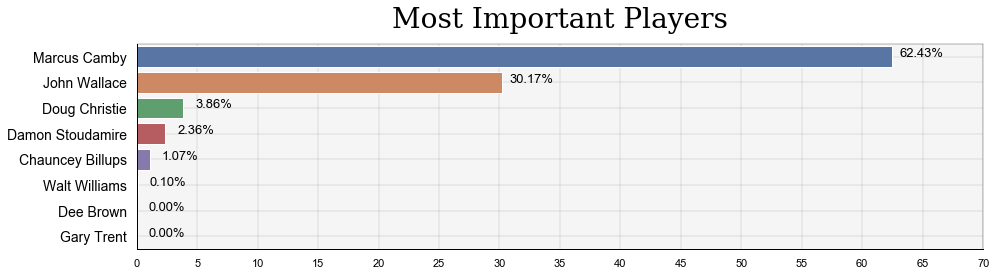

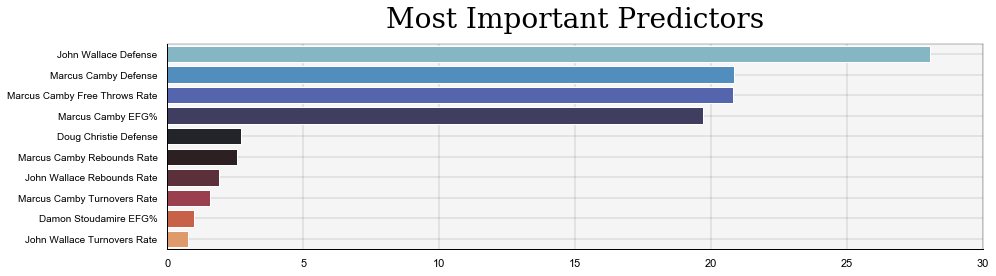

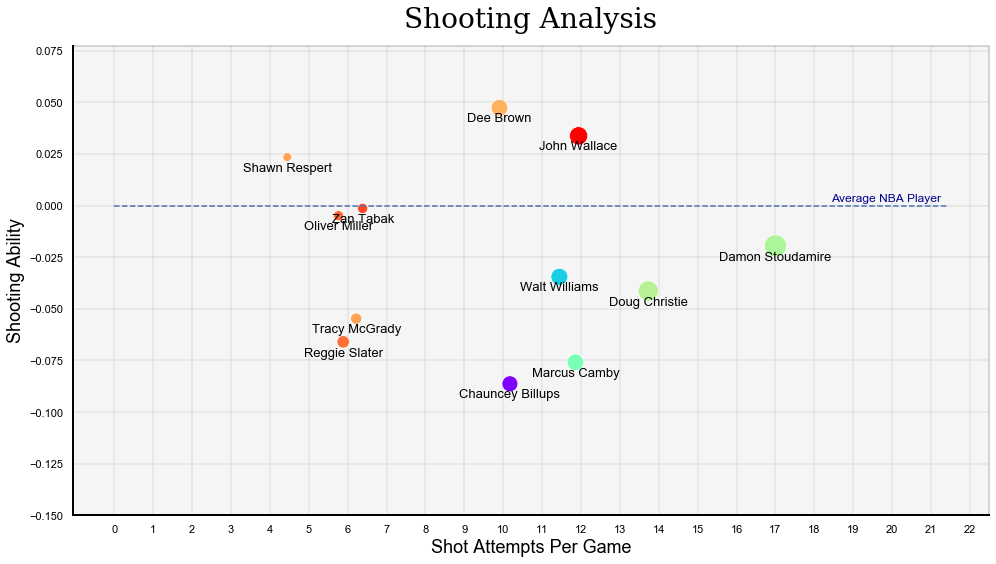

In [134]:
summarize_everything('TOR', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.68trial/s, best loss: -0.8638095238095239]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 46.7                          50.3
1   Rebounding                 22.1                          16.8
2    Turnovers                 18.0                          20.7
3  Free Throws                 13.3                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.33trial/s, best loss: -0.8333333333333333]


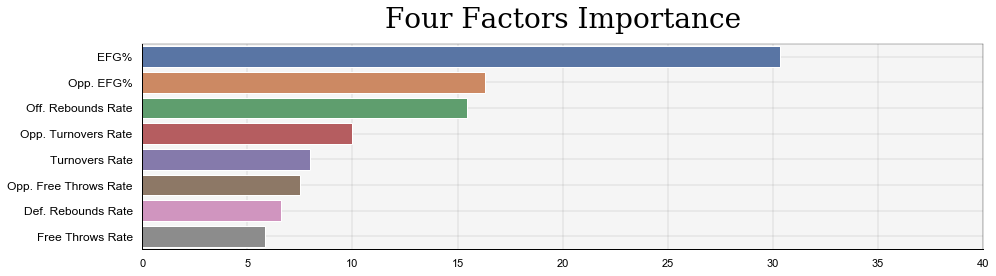

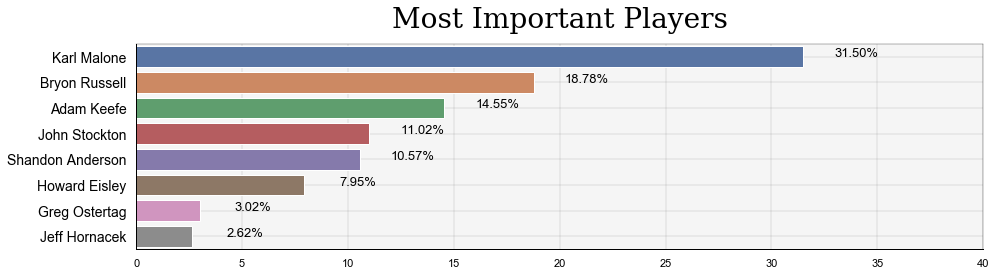

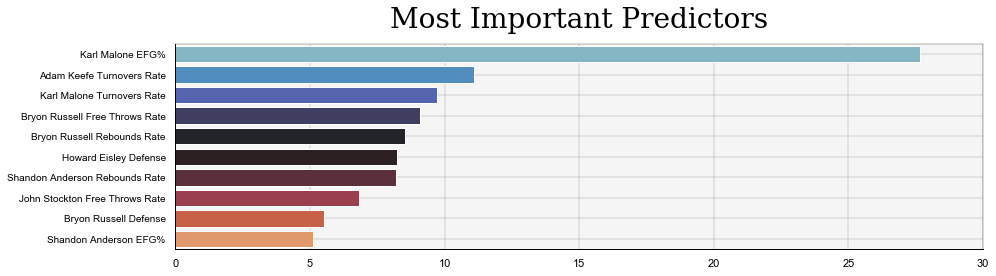

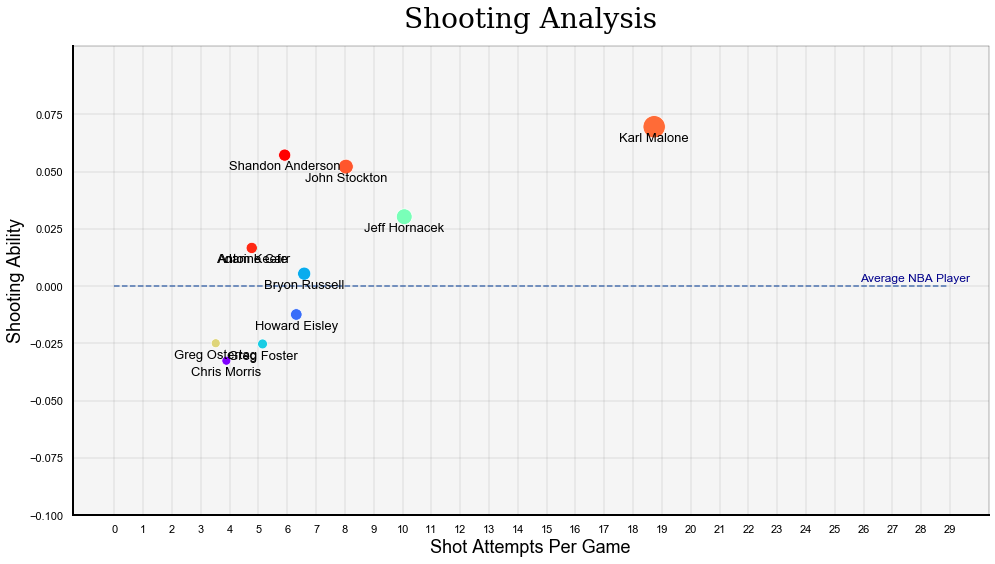

In [135]:
summarize_everything('UTA', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  6.96trial/s, best loss: -0.8669117647058823]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 45.5                          50.3
1   Rebounding                 29.2                          16.8
2    Turnovers                  6.2                          20.7
3  Free Throws                 19.1                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.54trial/s, best loss: -0.7933823529411764]


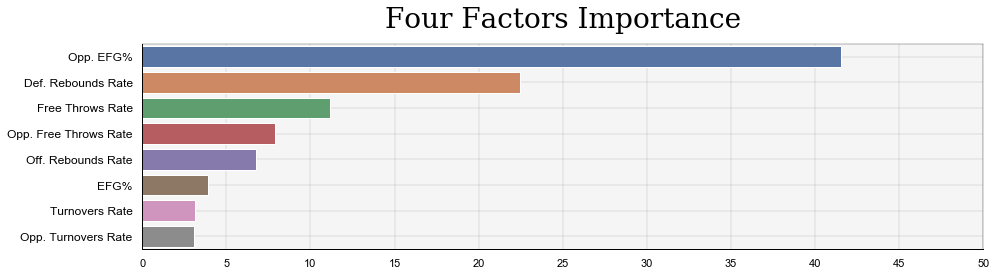

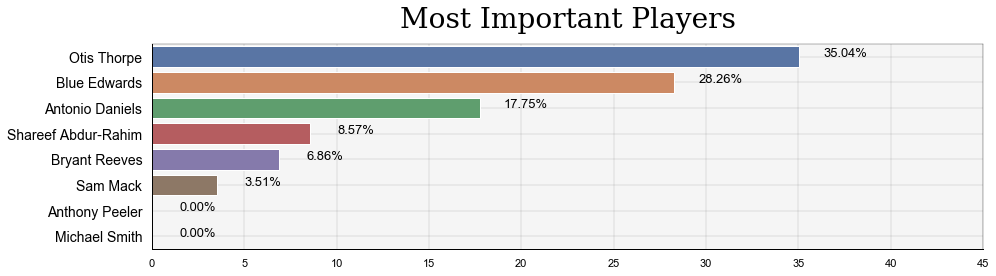

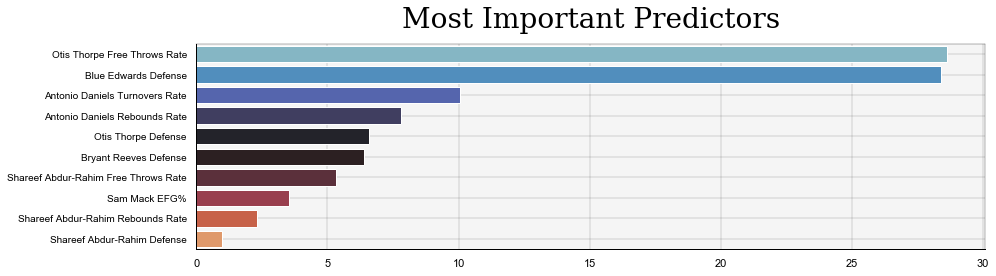

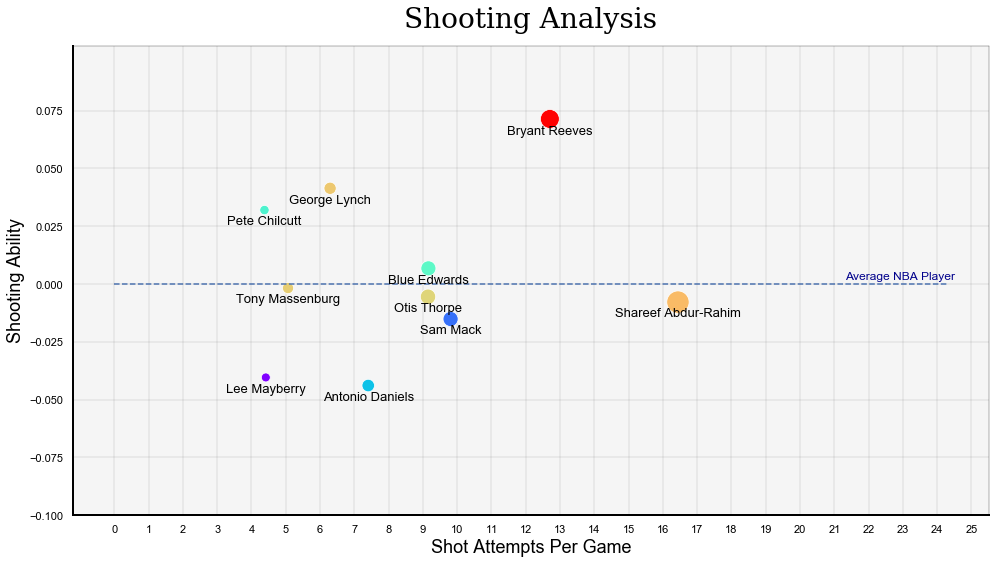

In [136]:
summarize_everything('VAN', '1997-98 Season')

100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.39trial/s, best loss: -0.8161764705882353]


       Factors  Importance for them  Importance for Avg. NBA Team
0     Shooting                 63.9                          50.3
1   Rebounding                  6.0                          16.8
2    Turnovers                 20.3                          20.7
3  Free Throws                  9.8                          12.2
4        TOTAL                100.0                         100.0
100%|███████████████████████████████████████████████| 60/60 [00:09<00:00,  6.10trial/s, best loss: -0.8044117647058823]


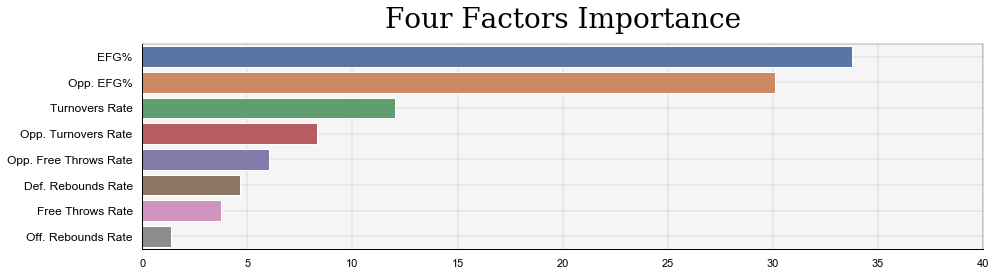

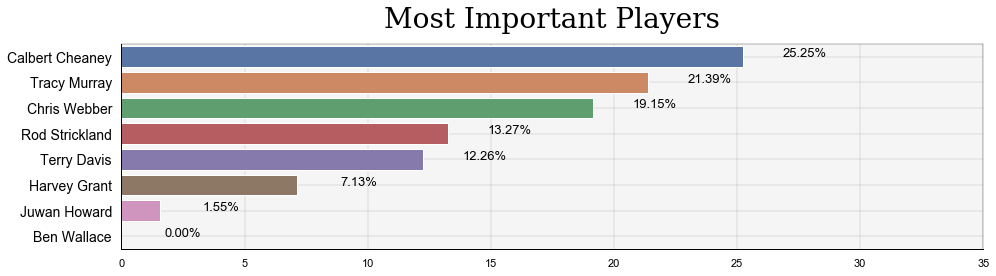

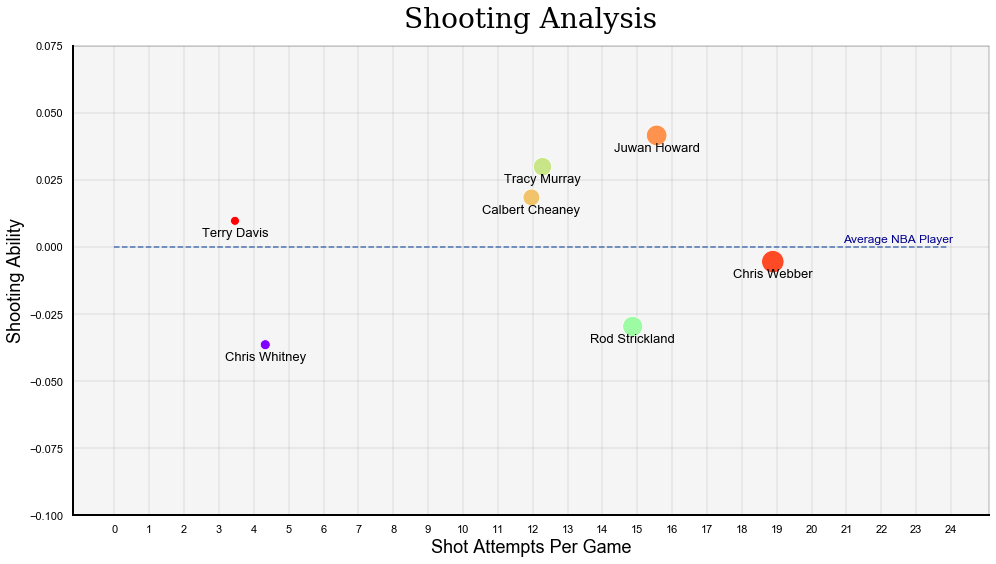

In [137]:
summarize_everything('WAS', '1997-98 Season')